## Session 7

### Spark Structured Streaming
- **Stream processing** is defined as the continuous processing of endless streams of data.
- With the advent of big data, stream processing systems transitioned from single-node processing engines to multiple-node, distributed processing engines.
- Traditionally, distributed stream processing has been implemented with a record-at-a-time processing model.

   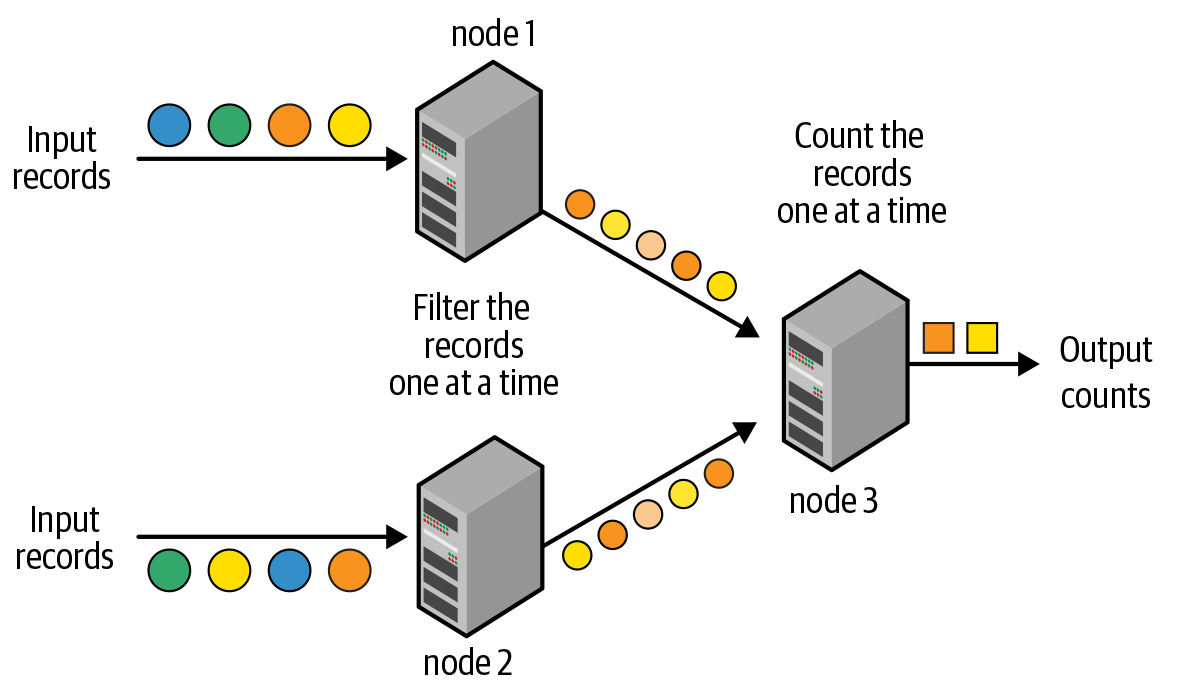

- In the traditional record-at-a-time processing model,each is continuously receive one record at time,process it, and then forwards the generated record(s) to the next node in the graph.
- Drawbacks:
  - Very low latency
    - An input record can be processed by the pipeline and the resulting output can be generated within milliseconds. 
  - Not very efficient at recovering from node failure
    - It can either recover from a failure very fast with a lot of extra failover resources, or use minimal extra resources but recover slowly.

- Traditional approach was challenged by Apache Spark when it introduced Spark Streaming (also called DStreams). 
- It introduced the idea of micro-batch stream processing, where the streaming computation is modeled as a continuous series of small, map/reduce-style batch processing jobs (hence, “micro-batches”) on small chunks of the stream data. 

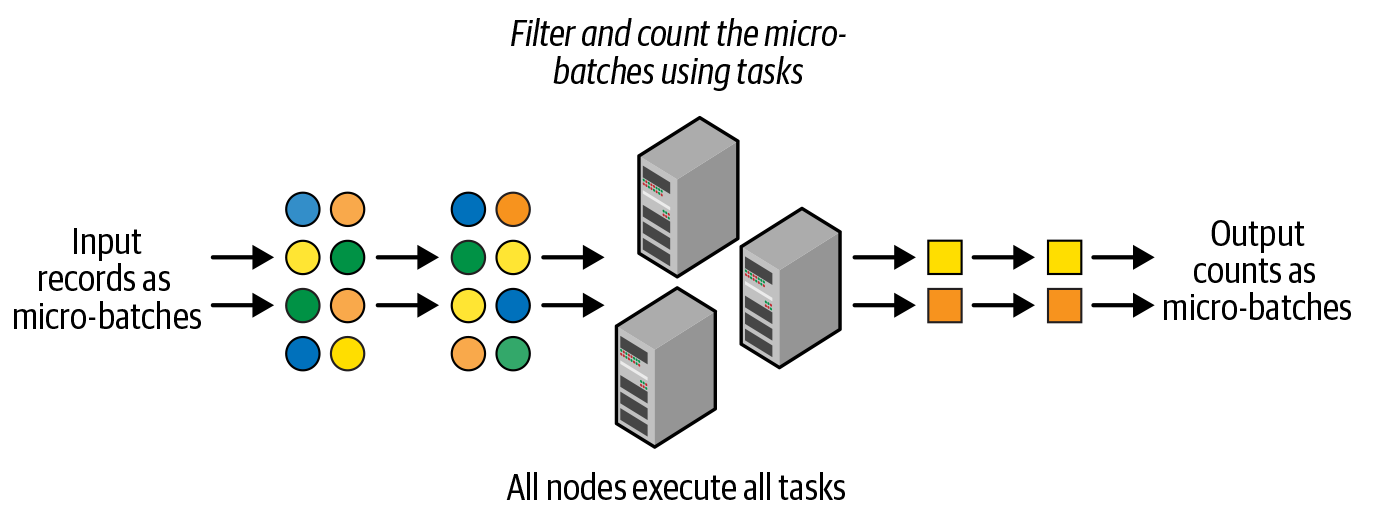

- In Spark Streaming,
  - Input Data divides into one second micro-batches.
  - Each batch is processed on spark cluster in distributed manner with small deterministic tasks that generate output in micro-batches.
  - It overcomes drawbacks of traditional model:
    -  Efficient Fault tolerance:Spark’s agile task scheduling can very quickly and efficiently recover from failures and straggler executors by rescheduling one or more copies of the tasks on any of the other executors.
    - The deterministic nature of the tasks ensures that the output data is the same no matter how many times the task is reexecuted. This crucial characteristic enables Spark Streaming to provide end-to-end exactly-once processing guarantees, that is, the generated output results will be such that every input record was processed exactly once.
   - The DStream API was built upon Spark’s batch RDD API,hence it has same functional semantics and fault-tolerance model as RDDs.
   - It is possible for a single, unified processing engine to provide consistent APIs and semantics for batch, interactive, and streaming work loads. 

##### Flaws of Spark streaming:
- Lack of a single API for batch and stream processing:
   -  Developers still had to explicitly rewrite their code to use different classes when converting their batch jobs to streaming jobs.
- Lack of separation between logical and physical plans:
  - Spark Streaming executes the DStream operations in the same sequence in which they were specified by the developer. Since developers effectively specify the exact physical plan, there is no scope for automatic optimizations, and developers have to hand-optimize their code to get the best performance.
- Lack of native support for event-time windows:
  - DStreams define window operations based only on the time when each record is received by Spark Streaming (known as processing time). However, many use cases need to calculate windowed aggregates based on the time when the records were generated (known as event time) instead of when they were received or processed. The lack of native support of event-time windows made it hard for developers to build such pipelines with Spark Streaming.


##### The Philosophy of Structured Streaming:
- Writing stream processing pipelines should be as easy as writing batch pipelines. 
- Principles of Structured Streaming are:
  - A single, unified programming model and interface for batch and stream processing
    - Unified model offers simple API interface for both batch and stream processing
    - We can use familiar SQL or batch like DataFrame queries.
  - A broader definition of stream processing
    - Any application that periodically (e.g., every few hours) to continuously (like traditional streaming applica‐ tions) processes data should be expressible using Structured Streaming.

##### The Programming Model of Structured Streaming:

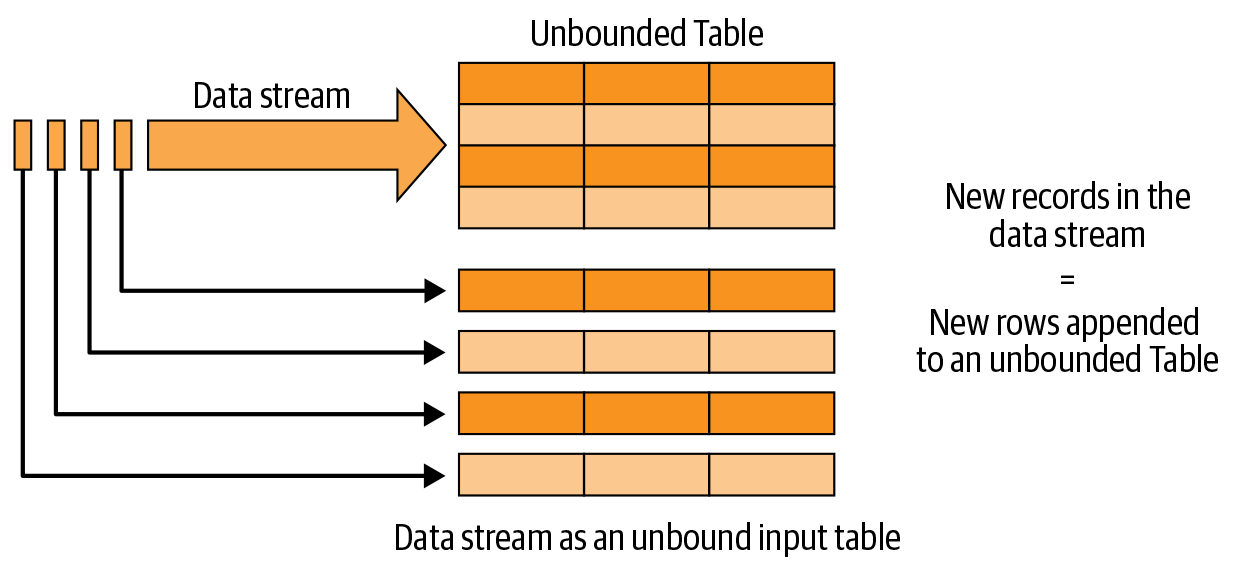

- The key idea in Structured Streaming is to treat a live data stream as an unbounded,a table that is being continuously appended. 
- Consider the input data stream as the “Input Table”. Every data item that is arriving on the stream is like a new row being appended to the Input Table.
- A query on the input will generate the “Result Table”. Every trigger interval (say, every 1 second), new rows get appended to the Input Table, which eventually updates the Result Table. Whenever the result table gets updated, we would want to write the changed result rows to an external sink.
- The “Output” is defined as what gets written out to the external storage,such as a filesystem (e.g., HDFS, Amazon S3) or a database (e.g., MySQL, Cassandra).. The output can be defined in a different mode:
  - Complete Mode - The entire updated Result Table will be written to the external storage. It is up to the storage connector to decide how to handle writing of the entire table.

  - Append Mode - Only the new rows appended in the Result Table since the last trigger will be written to the external storage. This is applicable only on the queries where existing rows in the Result Table are not expected to change.

  - Update Mode - Only the rows that were updated in the Result Table since the last trigger will be written to the external storage (available since Spark 2.1.1). Note that this is different from the Complete Mode in that this mode only outputs the rows that have changed since the last trigger. If the query doesn’t contain aggregations, it will be equivalent to Append mode.


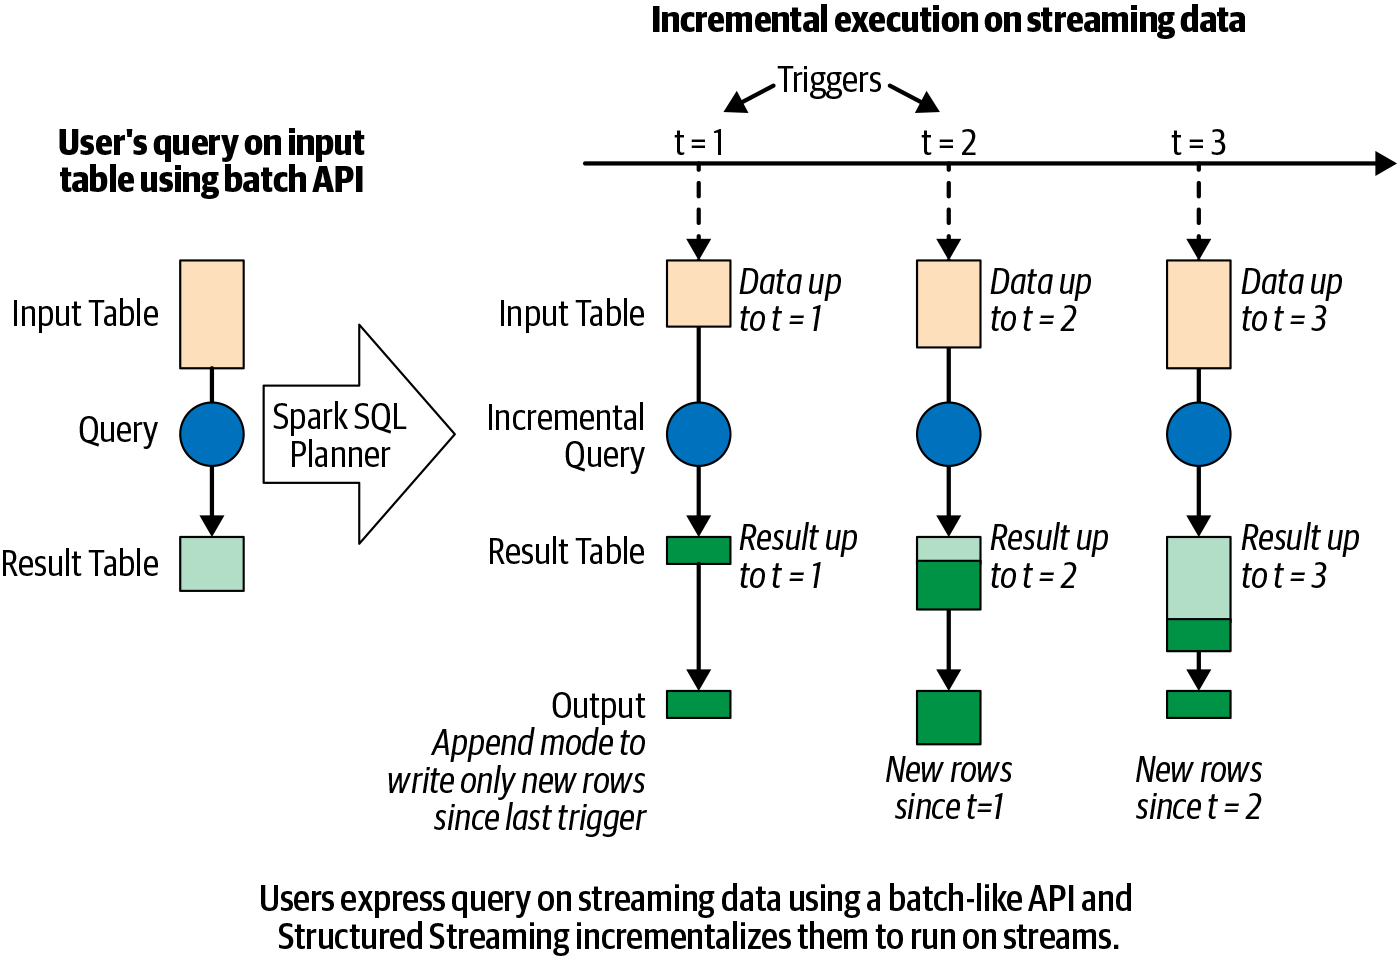

##### Five Steps to Define a Streaming Query:
1. Define input source:
   - As with batch queries, the first step is to define a DataFrame from a streaming source.
   - To read batch data source ,we need **spark.read to create a DataFrameReader**, whereas with **streaming sources we need spark.readStream to create a DataStreamReader.
   - Both DataFrameReader and DataStreamReader has same methods.
   - Example to create dataframe from a text data stream to received over a socket connection:
     - lines=spark.readStream.format("Socket").option("host","localhost").option("port","9999").load()
     - This code generates the lines DataFrame as an unbounded table of newline separated text data read from localhost:9999.
     - Note that, similar to batch sources with spark.read, this does not immediately start reading the streaming data; it only sets up the configurations necessary for reading the data once the streaming query is explicitly started.
     - Besides sockets, Apache Spark natively supports reading data streams from Apache Kafka and all the various file-based formats that DataFrameReader supports (Parquet, ORC, JSON, etc.).
2.  Transform data:
   - We can apply the usual DataFrame operations, such as splitting the lines into individual words and then counting them
   - Example:
     - from pyspark.sql.functions import *
     - words = lines.select(split(col("value"), "\\s").alias("word")) counts = words.groupBy("word").count()
     - These operations to transform the lines streaming DataFrame would work in the exact same way if lines were a batch DataFrame.
   - Two broad classes of data transformation:
     1. Stateless Transformations
        - Operations like select(), filter(), map(), etc. do not require any information from previous rows to process the next row; each row can be processed by itself
        - Applied to both batch and streaming DataFrames.
     2. Stateful Transformations
        - An aggregation operation like count() requires maintaining state to combine data across multiple rows.
        - DataFrame operations involving grouping, joining, or aggregating are stateful transformations.
        - While many of these operations are supported in Structured Streaming, a few combinations of them are not supported because it is either computationally hard or infeasible to compute them in an incremental manner.
3. Define output sink and output mode   
   - After transforming the data, we can define how to write the processed output data with DataFrame.writeStream (instead of DataFrame.write, used for batch data). This creates a DataStreamWriter which, similar to DataFrameWriter, has additional methods to specify the following:
        - Output writing details (where and how to write the output)
        - Processing details (how to process data and how to recover from failures)
   - Example:
       - writer = counts.writeStream.format("console").outputMode("complete")
       - The output mode of a streaming query specifies what part of the updated output to write out after processing new input data.
       - Output Modes
         - Append Mode
           - Default mode
           - Only the new rows added to the result table/Data‐ Frame (for example, the counts table) since the last trigger will be output to the sink.
           - Supported by only those queries (e.g., stateless queries) that will never modify previously output data.
         - Complete Mode
           - All the rows of the result table/DataFrame will be output at the end of every trigger.
           - This is supported by queries where the result table is likely to be much smaller than the input data and therefore can feasibly be retained in memory.
         - Update Mode
           - Only the rows of the result table/DataFrame that were updated since the last trigger will be output at the end of every trigger.
           -  This is in contrast to append mode, as the output rows may be modified by the query and output again in the future. 
- Besides writing the output to the console, Structured Streaming natively supports streaming writes to files and Apache Kafka. In addition, you can write to arbitrary locations using the foreachBatch() and foreach() API methods. In fact, you can use foreachBatch() to write streaming outputs using existing batch data sources (but you will lose exactly-once guarantees).
4.  Specify processing details
  - The final step before starting the query is to specify details of how to process the data.
  - Two types of details using the DataStreamWriter that we created with DataFrame.writeStream:
    - Triggering details
      - This indicates when to trigger the discovery and processing of newly available streaming data. There are four options:
        - Default
           - When the trigger is not explicitly specified, then by default, the streaming query executes data in micro-batches where the next micro-batch is trig‐ gered as soon as the previous micro-batch has completed.
        - Processing time with trigger interval
           - You can explicitly specify the ProcessingTime trigger with an interval, and the query will trigger micro-batches at that fixed interval.
         - Once
           - In this mode, the streaming query will execute exactly one micro-batch—it processes all the new data available in a single batch and then stops itself. This is useful when you want to control the triggering and processing from an external scheduler that will restart the query using any custom schedule (e.g., to control cost by only executing a query once per day).
         - Continuous
           - This is an experimental mode (as of Spark 3.0) where the streaming query will process data continuously instead of in micro-batches. While only a small subset of DataFrame operations allow this mode to be used, it can pro‐ vide much lower latency (as low as milliseconds) than the micro-batch trig‐ ger modes. Refer to the latest Structured Streaming Programming Guide for the most up-to-date information.
    - Checkpoint location
       - This is a directory in any HDFS-compatible filesystem where a streaming query saves its progress information—that is, what data has been successfully pro‐ cessed. Upon failure, this metadata is used to restart the failed query exactly where it left off. Therefore, setting this option is necessary for failure recovery with exactly-once guarantees.
- Example 
   - .trigger(processingTime="1 second")
      .option("checkpointLocation", checkpointDir)
5. Start the query: 
   - start() is a nonblocking method, so it will return as soon as the query has started in the background. 
   - If you want the main thread to block until the streaming query has terminated, you can use streamingQuery.awaitTermination(). 
   - If the query fails in the background with an error, awaitTermination() will also fail with that same exception.
- You can wait up to a timeout duration using awaitTermination(timeoutMillis), and you can explicitly stop the query with streamingQuery.stop().


In [ ]:
import pyspark
from pyspark import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

#Create DataFrame representing the stream of input lines from connection to localhost:9999
spark=SparkSession.builder.appName("Python Spark Streaming Demo").config("spark.some.config.option","some-value").getOrCreate()
lines=spark.readStream.format("Socket").option("host","localhost").option("port","9999").load()

# Split the lines into words
words = lines.select(
   explode(
       split(lines.value, " ")
   ).alias("word")
)

In [ ]:
splitDf=lines.select(split(lines.value,"\\s").alias("word"))
splitViewDf=splitDf.select(splitDf.word[0].alias("Name"),splitDf.word[1].alias("Age"))

#Start data streaming 
query=splitViewDf.writeStream.outputMode("append").format("console").start().awaitTermination()

##### Install NatCat server :

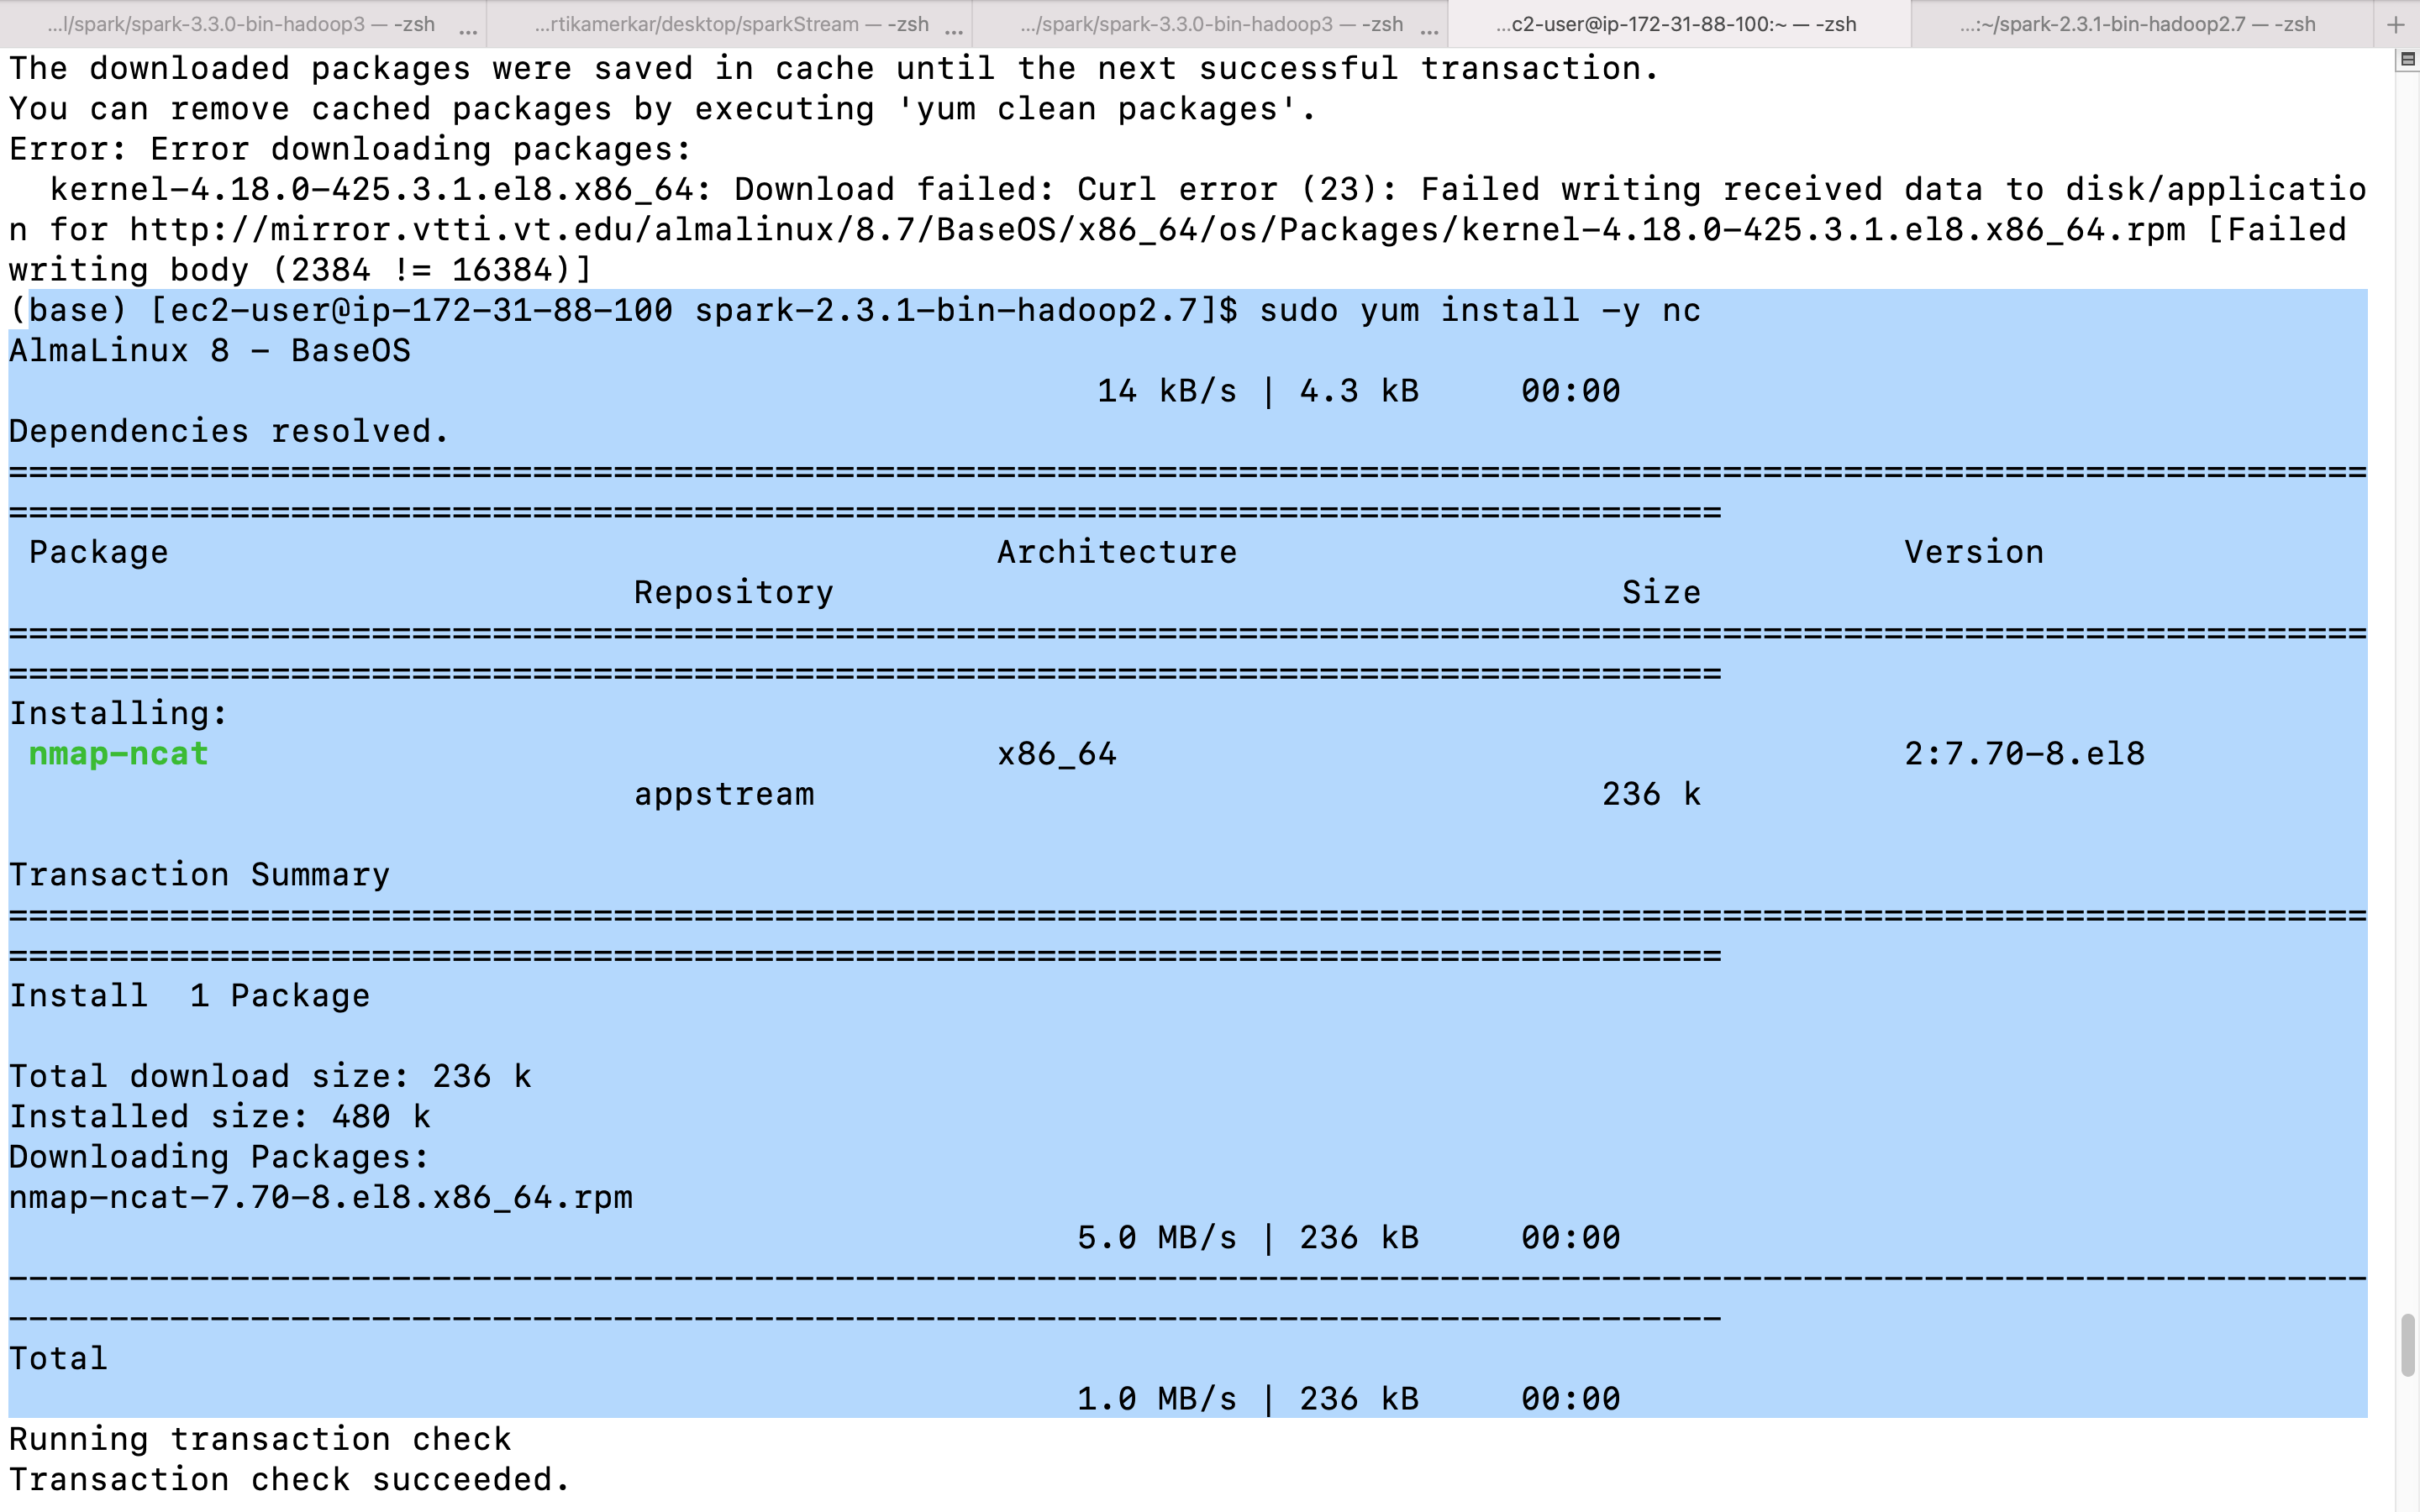

##### Under the Hood of an Active Streaming Query:
- Once query has started, Dataframe operations are converted into the logical plan.
- SPARK SQL analyzes and optimizes this logical plan to ensure that it can be executed incrementally and efficiently on streaming data.
- Spark SQL starts background thread.
  - Based on the configured trigger interval, the thread checks the streaming sources for the availability of new data.
  - If new data available ,it executed by running micro batch.From the optimized logical plan, an optimized Spark execution plan is generated that reads the new data from the source, incrementally computes the updated result, and writes the output to the sink according to the configured output mode.
  - For every micro-batch, the exact range of data processed (e.g., the set of files or the range of Apache Kafka offsets) and any associated state are saved in the configured checkpoint location so that the query can deterministically reproc‐ ess the exact range if needed.
-  This loop continues until the query is terminated, which can occur for one of the following reasons:
   1. A failure has occurred in the query (either a processing error or a failure in the cluster).
   2. The query is explicitly stopped using streamingQuery.stop().
   3. If the trigger is set to Once, then the query will stop on its own after executing
      a single micro-batch containing all the available data. 
  

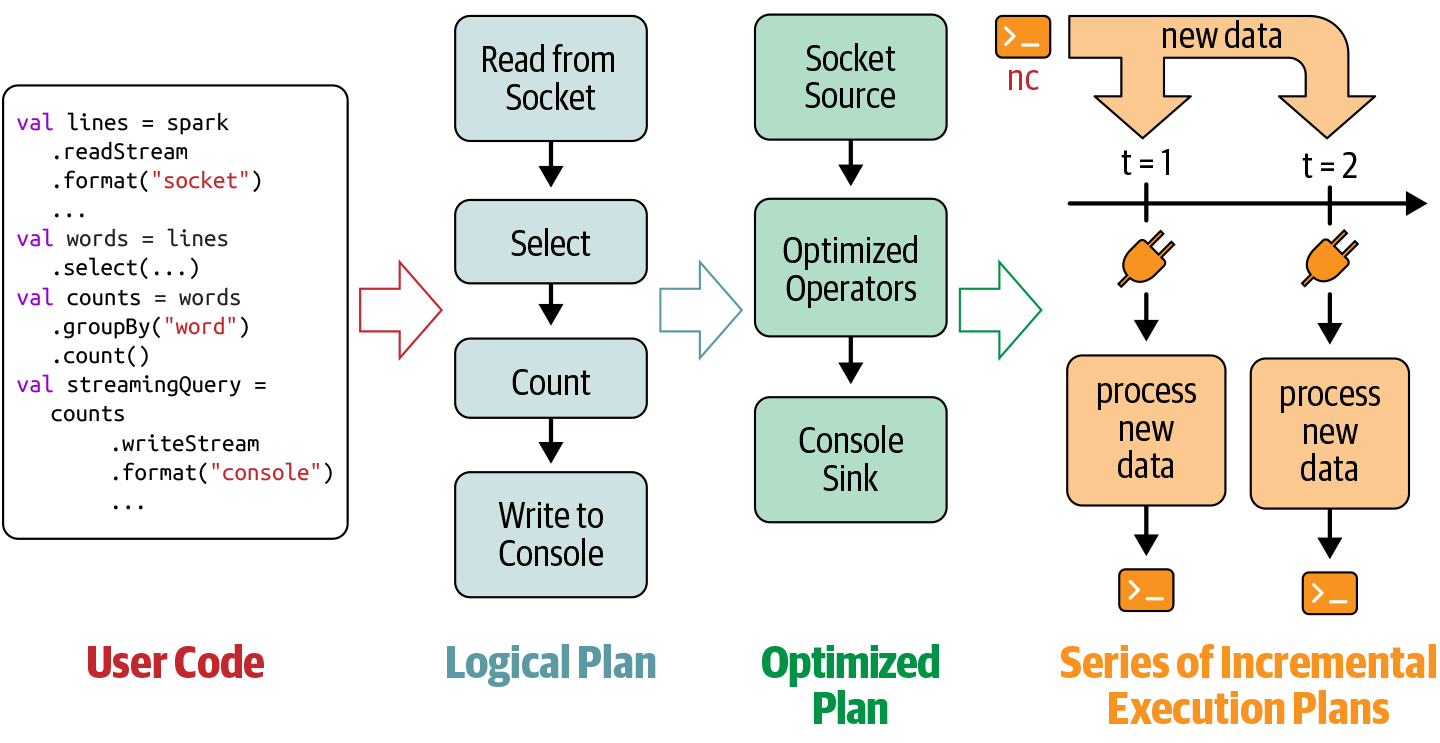

##### Streaming Data Sources and Sinks
- ##### How to use the built-in streaming data sources and sinks?
  - AS we know,you can **create DataFrames from streaming sources using SparkSession.readStream() and write the output from a result DataFrame using DataFrame.writeStream()**. In each case, you can **specify the source type using the method format()**. 
  - Structured Streaming supports reading and writing data streams to and from files in the same formats as the ones supported in batch processing: plain text, CSV, JSON, Parquet, ORC, etc.
  - Reading from files:Structured Streaming can treat files written into a directory as a data stream.
    - from pyspark.sql.types import * 
    - inputDirectoryOfJsonFiles = (path to file)...
    - fileSchema = (StructType()
    - .add(StructField("key", IntegerType()))
    -  .add(StructField("value", IntegerType())))
    - inputDF = (spark
    -  .readStream
    - .format("json")
    - .schema(fileSchema)
    - .load(inputDirectoryOfJsonFiles))

In [ ]:
##Loading data from files
# season,date_code,weekending,region,Respiratory_Virus,Number_Positive,Specimens_Tested,Percent_Positive
from pyspark.sql.types import *

#inputDirectoryOfCSVFiles = "/home/ec2-user/influenza.csv"
fileSchema = (StructType().add(StructField("season", StringType())) \
              .add(StructField("date_code", StringType())) \
              .add(StructField("weekending",StringType())) \
              .add(StructField("region",StringType())) \
              .add(StructField("Respiratory_Virus",StringType())) \
              .add(StructField("Number_Positive",StringType())).add(StructField("Specimens_Tested",StringType())) \
              .add(StructField("Percent_Positive",StringType())))

# Loading/ Reading data from file using readStream()
dfInput = spark\
         .readStream \
         .format("csv") \
         .option("header",True) \
         .option("path","/Users/kirtikamerkar/Austincapitaldata/data_engineer_curr/data/raw/CHHS_flu_10_13_2022/clinical-sentinel-laboratory-influenza-and-other-respiratory-virus-surveillance-data-by-region-and-influenza-season*.csv") \
         .schema(fileSchema) \
         .load()
# Streaming Data on console
Query=dfInput.writeStream.format("console").outputMode("append").start().awaitTermination()

#Writing Data to file
dfInput.writeStream.format("csv").option("header",True).outputMode("append").option("path","/Users/kirtikamerkar/Austincapitaldata/data_engineer_curr/data/external/").option("checkpointLocation","/Users/kirtikamerkar/Austincapitaldata/data_engineer_curr/checkPoint").start()

In [ ]:
dfInputCount=dfInput.groupBy("date_code").count()

In [ ]:
InfluQuery=infludf.writeStream.format("console").outputMode("append").start().awaitTermination()

In [ ]:
df=dfInput.select("season","date_code","Respiratory_Virus")
dfQuery=df.writeStream.format("console").outputMode("append").start().awaitTermination()

In [ ]:
# Streaming Data on console
Query=dfInputCount.writeStream.format("console").outputMode("complete").start().awaitTermination()

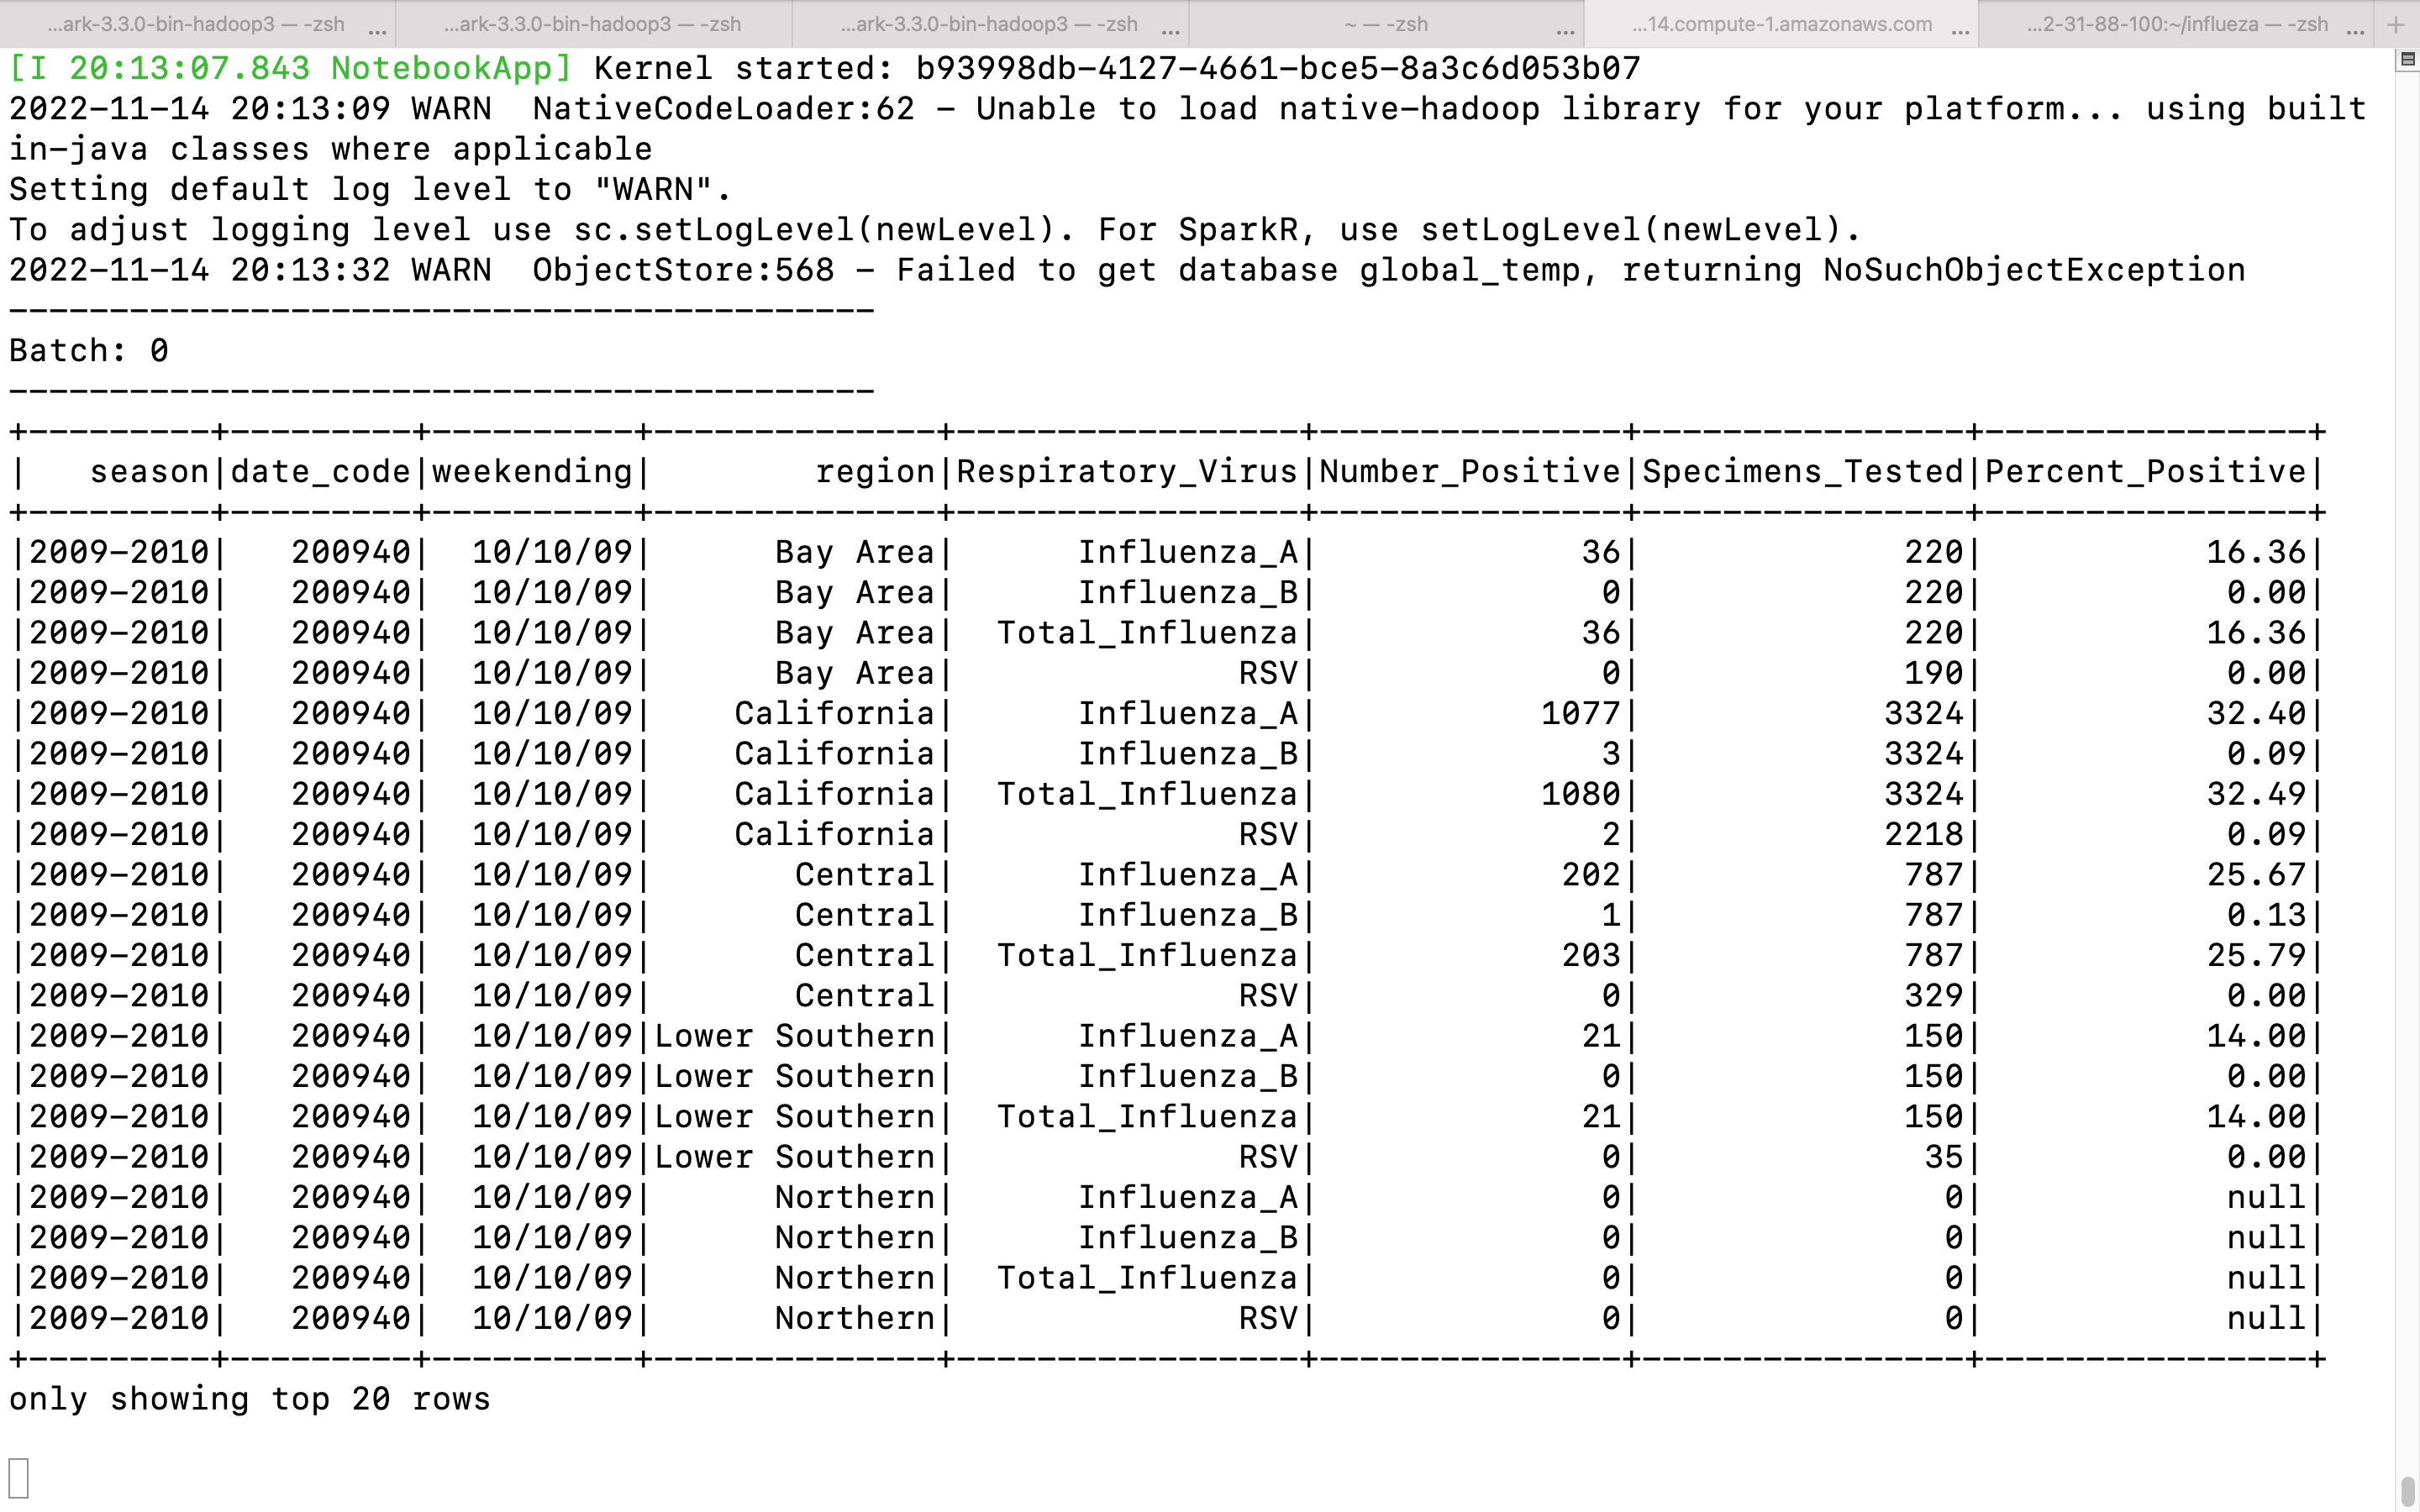

##### Checkpoints:
- **A checkpoint helps build fault-tolerant and resilient Spark applications. In Spark Structured Streaming, it maintains intermediate state on HDFS compatible file systems to recover from failures. To specify the checkpoint in a streaming query, we use the checkpointLocation parameter**.



##### Streaming with Kafka
- What is Apache Kafka?
  - Kafka is a distributed system consisting of servers and clients that communicate via a high-performance TCP network protocol.
  - Kafka combines three key capabilities so you can implement your use cases for event streaming end-to-end with a single battle-tested solution:

    - To publish (write) and subscribe to (read) streams of events, including continuous import/export of your data from other systems.
    - To store streams of events durably and reliably for as long as you want.
    - To process streams of events as they occur or retrospectively.
  - Structured Streaming has built-in support for reading from and writing to Apache Kafka.
- Kafka Setup:[Kafka Installation](https://kafka.apache.org/quickstart)
  - Install kafka
  - Go to config folder and update server.properties with 
     - advertised.listeners=PLAINTEXT://localhost:9092
     - Save it.
  - Start zookeeper with:
     - ./bin/zookeeper-server-start.sh config/zookeeper.properties
  - Start kafka server:
    - ./bin/kafka-server-start.sh config/server.properties 
  - Create kafka topic :
    - **bin/kafka-topics.sh --create --topic quickstart-events --bootstrap-server localhost:9092**
    - **bin/kafka-topics.sh --describe --topic quickstart-events --bootstrap-server localhost:9092**
    - **Topic: quickstart-events	TopicId: ulFJkK_RRf-gTVgNqKQL9A	PartitionCount: 1	ReplicationFactor: 1	Configs:** 
	- **Topic: quickstart-events	Partition: 0	Leader: 0	Replicas: 0	Isr: 0**

  - bin/kafka-console-consumer.sh --topic quickstart-events --from-beginning --bootstrap-server localhost:9092


##### Main Concepts and Terminology:
- Producers are those client applications that publish (write) events to Kafka, and consumers are those that subscribe to (read and process) these events. 
- Kafka consists of Records, Topics, Consumers, Producers, Brokers, and Clusters. 
- Records can have key (optional), value and timestamp.
   - KafkaRecordsareimmutable.
- A Kafka Topic is a stream of records (“/orders”, “/user-signups”).Events are organized and durably stored in topics.
  - Topics are partitioned, meaning a topic is spread over a number of "buckets" located on different Kafka brokers. This distributed placement of your data is very important for scalability because it allows client applications to both read and write the data from/to many brokers at the same time.
  - YoucanthinkofaTopicasafeedname.
- A topic has a Log which is the topic's storage on disk.
  - ATopicLogisbrokenupintopartitionsandsegments.
- The Kafka Producer API is used to produce streams of data records.
- The Kafka Consumer API is used to consume a stream of records from Kafka.   A Broker is a Kafka server that runs in a Kafka Cluster.
  - KafkaBrokersformacluster.
  - TheKafkaClusterconsistsofmanyKafkaBrokersonmanyservers.
  - BrokersometimesrefertomoreofalogicalsystemorasKafkaasawhole.
- Kafka uses ZooKeeper to manage the cluster.
  - ZooKeeperisusedtocoordinatethebrokers/clustertopology.
  - ZooKeeperisaconsistentfilesystemforconfigurationinformation.
  - ZooKeepergetsusedforleadershipelectionforBrokerTopicPartitionLeaders.

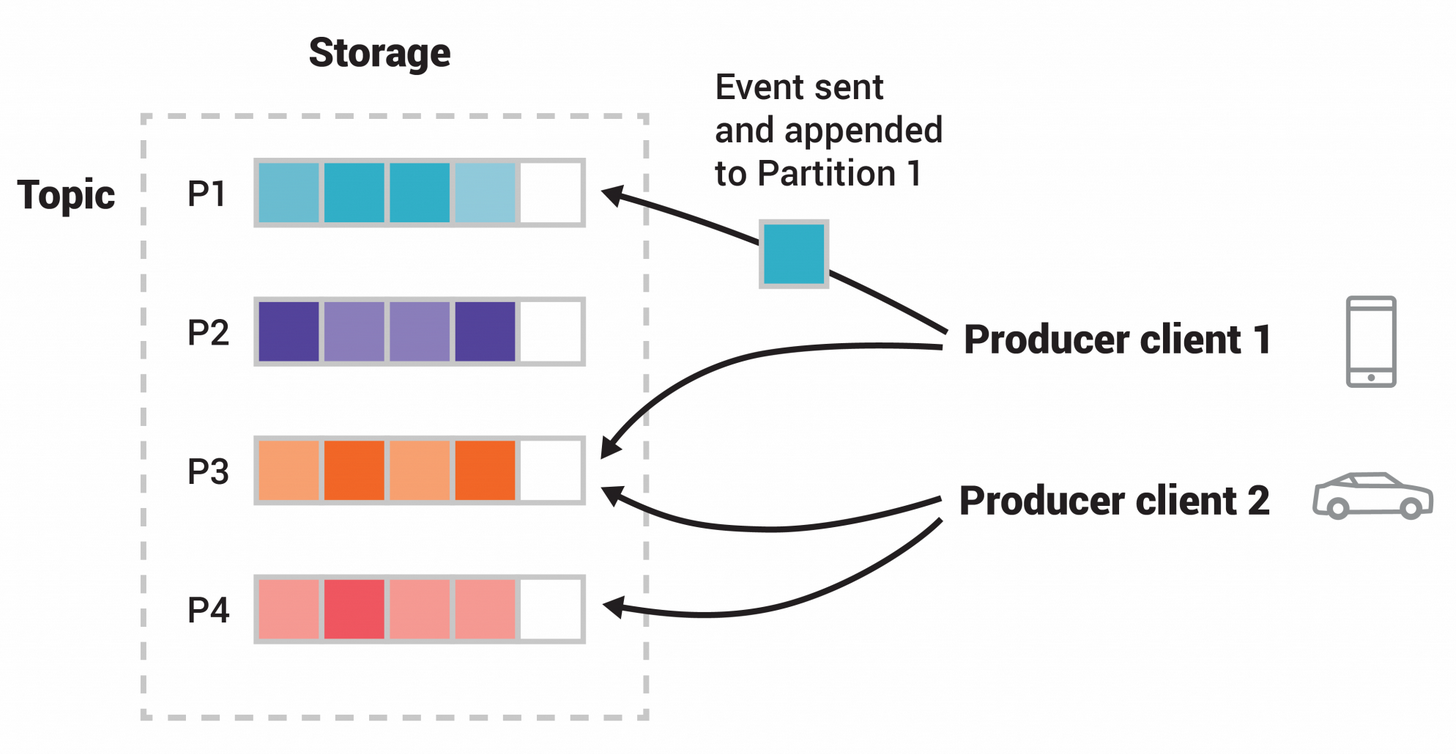

- **Above example topic has four partitions P1–P4. Two different producer clients are publishing, independently from each other, new events to the topic by writing events over the network to the topic's partitions. Events with the same key (denoted by their color in the figure) are written to the same partition. Note that both producers can write to the same partition if appropriate**.

In [ ]:
 inputDF = (spark
      .readStream
      .format("kafka")
      .option("kafka.bootstrap.servers", "localhost:9082")
      .option("subscribe", "voter")
.load())
voterDF=inputDF.selectExpr("CAST(value AS STRING) as json")    
schema=(StructType().add(StructField("gender", StringType())) \
              .add(StructField("age", IntegerType())) \
              .add(StructField("party",StringType())))


from pyspark.sql.functions import from_json, col
voterJSONDF = voterDF.select(from_json(col("value")
		.cast("string"),schema).alias("voterJSON"))
              

- To ingest as JSON, we use the from_json() function 
- In pyspark.sql.functions
  - Must specify the schema - no auto-scanning for streaming
  - We define the schema below, and apply it to our data 
   - We then aggregate by gender and party
   - voter affiliation is important info on election night !
- from pyspark.sql.types import StructType, StringType, LongType
-  from pyspark.sql.functions import from_json, col
- voterSchema = StructType().add("gender",StringType())
     .add("age",LongType())
     .add("party",StringType())
- from_json creates a nested strcuture (voterJSON is top level) (1)
   - **voterJSONDF = kafkaVoterDF.select(from_json(col("value").cast("string"), voterSchema).alias("voterJSON"))**
- To extract our data, we need to navigate through voterJSON
  - **voterStatsDF = voterJSONDF.groupBy("voterJSON.gender", "voterJSON.party").count()**

In [ ]:
# START copying here at beginning of lab (raw voter data streaming)

# Create streaming DataFrame reading from Kafka
kafkaVoterDF = spark.readStream.format("kafka").option("kafka.bootstrap.servers", "localhost:9092").option("subscribe", "voter").option("startingOffsets", "earliest").load()

# Query for and display raw data.
rawVoterQuery = kafkaVoterDF.writeStream.trigger(processingTime="10 seconds").outputMode("append").format("console").start()

# END copying here for raw voter data streaming.

# Optional DONE: Pull out the payload data as a string, then view it.

from pyspark.sql.functions import from_json, split, explode, col, lower

voterStringDF = kafkaVoterDF.select(col("value").cast("string")).alias("voterString")

stringVoterQuery = voterStringDF.writeStream.trigger(processingTime="10 seconds").outputMode("append").format("console").option("truncate", "false").start()

# Once you're done, then check the status, then stop the query.
stringVoterQuery.status
stringVoterQuery.stop()

# END Optional payload data as a string.


# START: Processing JSON data.
# START copying here at beginning of lab (raw voter data streaming)

# Create streaming DataFrame reading from Kafka
kafkaVoterDF = spark.readStream.format("kafka").option("kafka.bootstrap.servers", "localhost:9092").option("subscribe", "voters").option("startingOffsets", "earliest").load()

# Query for and display raw data.
rawVoterQuery = kafkaVoterDF.writeStream.trigger(processingTime="10 seconds").outputMode("append").format("console").start()

# END copying here for raw voter data streaming.

# Optional DONE: Pull out the payload data as a string, then view it.

from pyspark.sql.functions import from_json, split, explode, col, lower

voterStringDF = kafkaVoterDF.select(col("value").cast("string")).alias("voterString")

stringVoterQuery = voterStringDF.writeStream.trigger(processingTime="10 seconds").outputMode("append").format("console").option("truncate", "false").start()

# Once you're done, then check the status, then stop the query.
stringVoterQuery.status
stringVoterQuery.stop()

# END Optional payload data as a string.


# START: Processing JSON data.

from pyspark.sql.types import StructType, StringType, LongType
voterSchema = StructType().add("gender",StringType()).add("age",LongType()).add("party",StringType())

from pyspark.sql.functions import from_json, col
voterJSONDF =  kafkaVoterDF.select(from_json(col("value")
		.cast("string"), voterSchema).alias("voterJSON"))


voterJSONDF.printSchema()
root
 |-- voterJSON: struct (nullable = true)
 |    |-- gender: string (nullable = true)
 |    |-- age: long (nullable = true)
 |    |-- party: string (nullable = true)

voterStatsDF = voterJSONDF.groupBy("voterJSON.gender", "voterJSON.party").count()

# Statistical data.
voterStatsQuery = voterStatsDF.writeStream.trigger(processingTime="1 minute").outputMode("complete").format("console").start()

# END Processing JSON data.


# Create the bucket column
binnedVoterDF = voterJSONDF.withColumn("bucket", ((col("voterJSON.age")-18) / 10).cast("int"))
  
# Analyze by buckets
binnedVoterDF.createOrReplaceTempView("binnedVoters")  
rangedVoterDF = spark.sql("SELECT bucket, bucket*10+18 AS startAge, (bucket+1)*10+18-1 AS endAge, voterJSON.party, count(*) FROM binnedVoters GROUP BY bucket, voterJSON.party ORDER BY bucket ASC")

# Start the query.
voterRangeQuery = rangedVoterDF.writeStream.trigger(processingTime="1 minute").outputMode("complete").format("console").start()

# Stop the Query:
voterRangeQuery.stop()

# END Process data into age buckets.


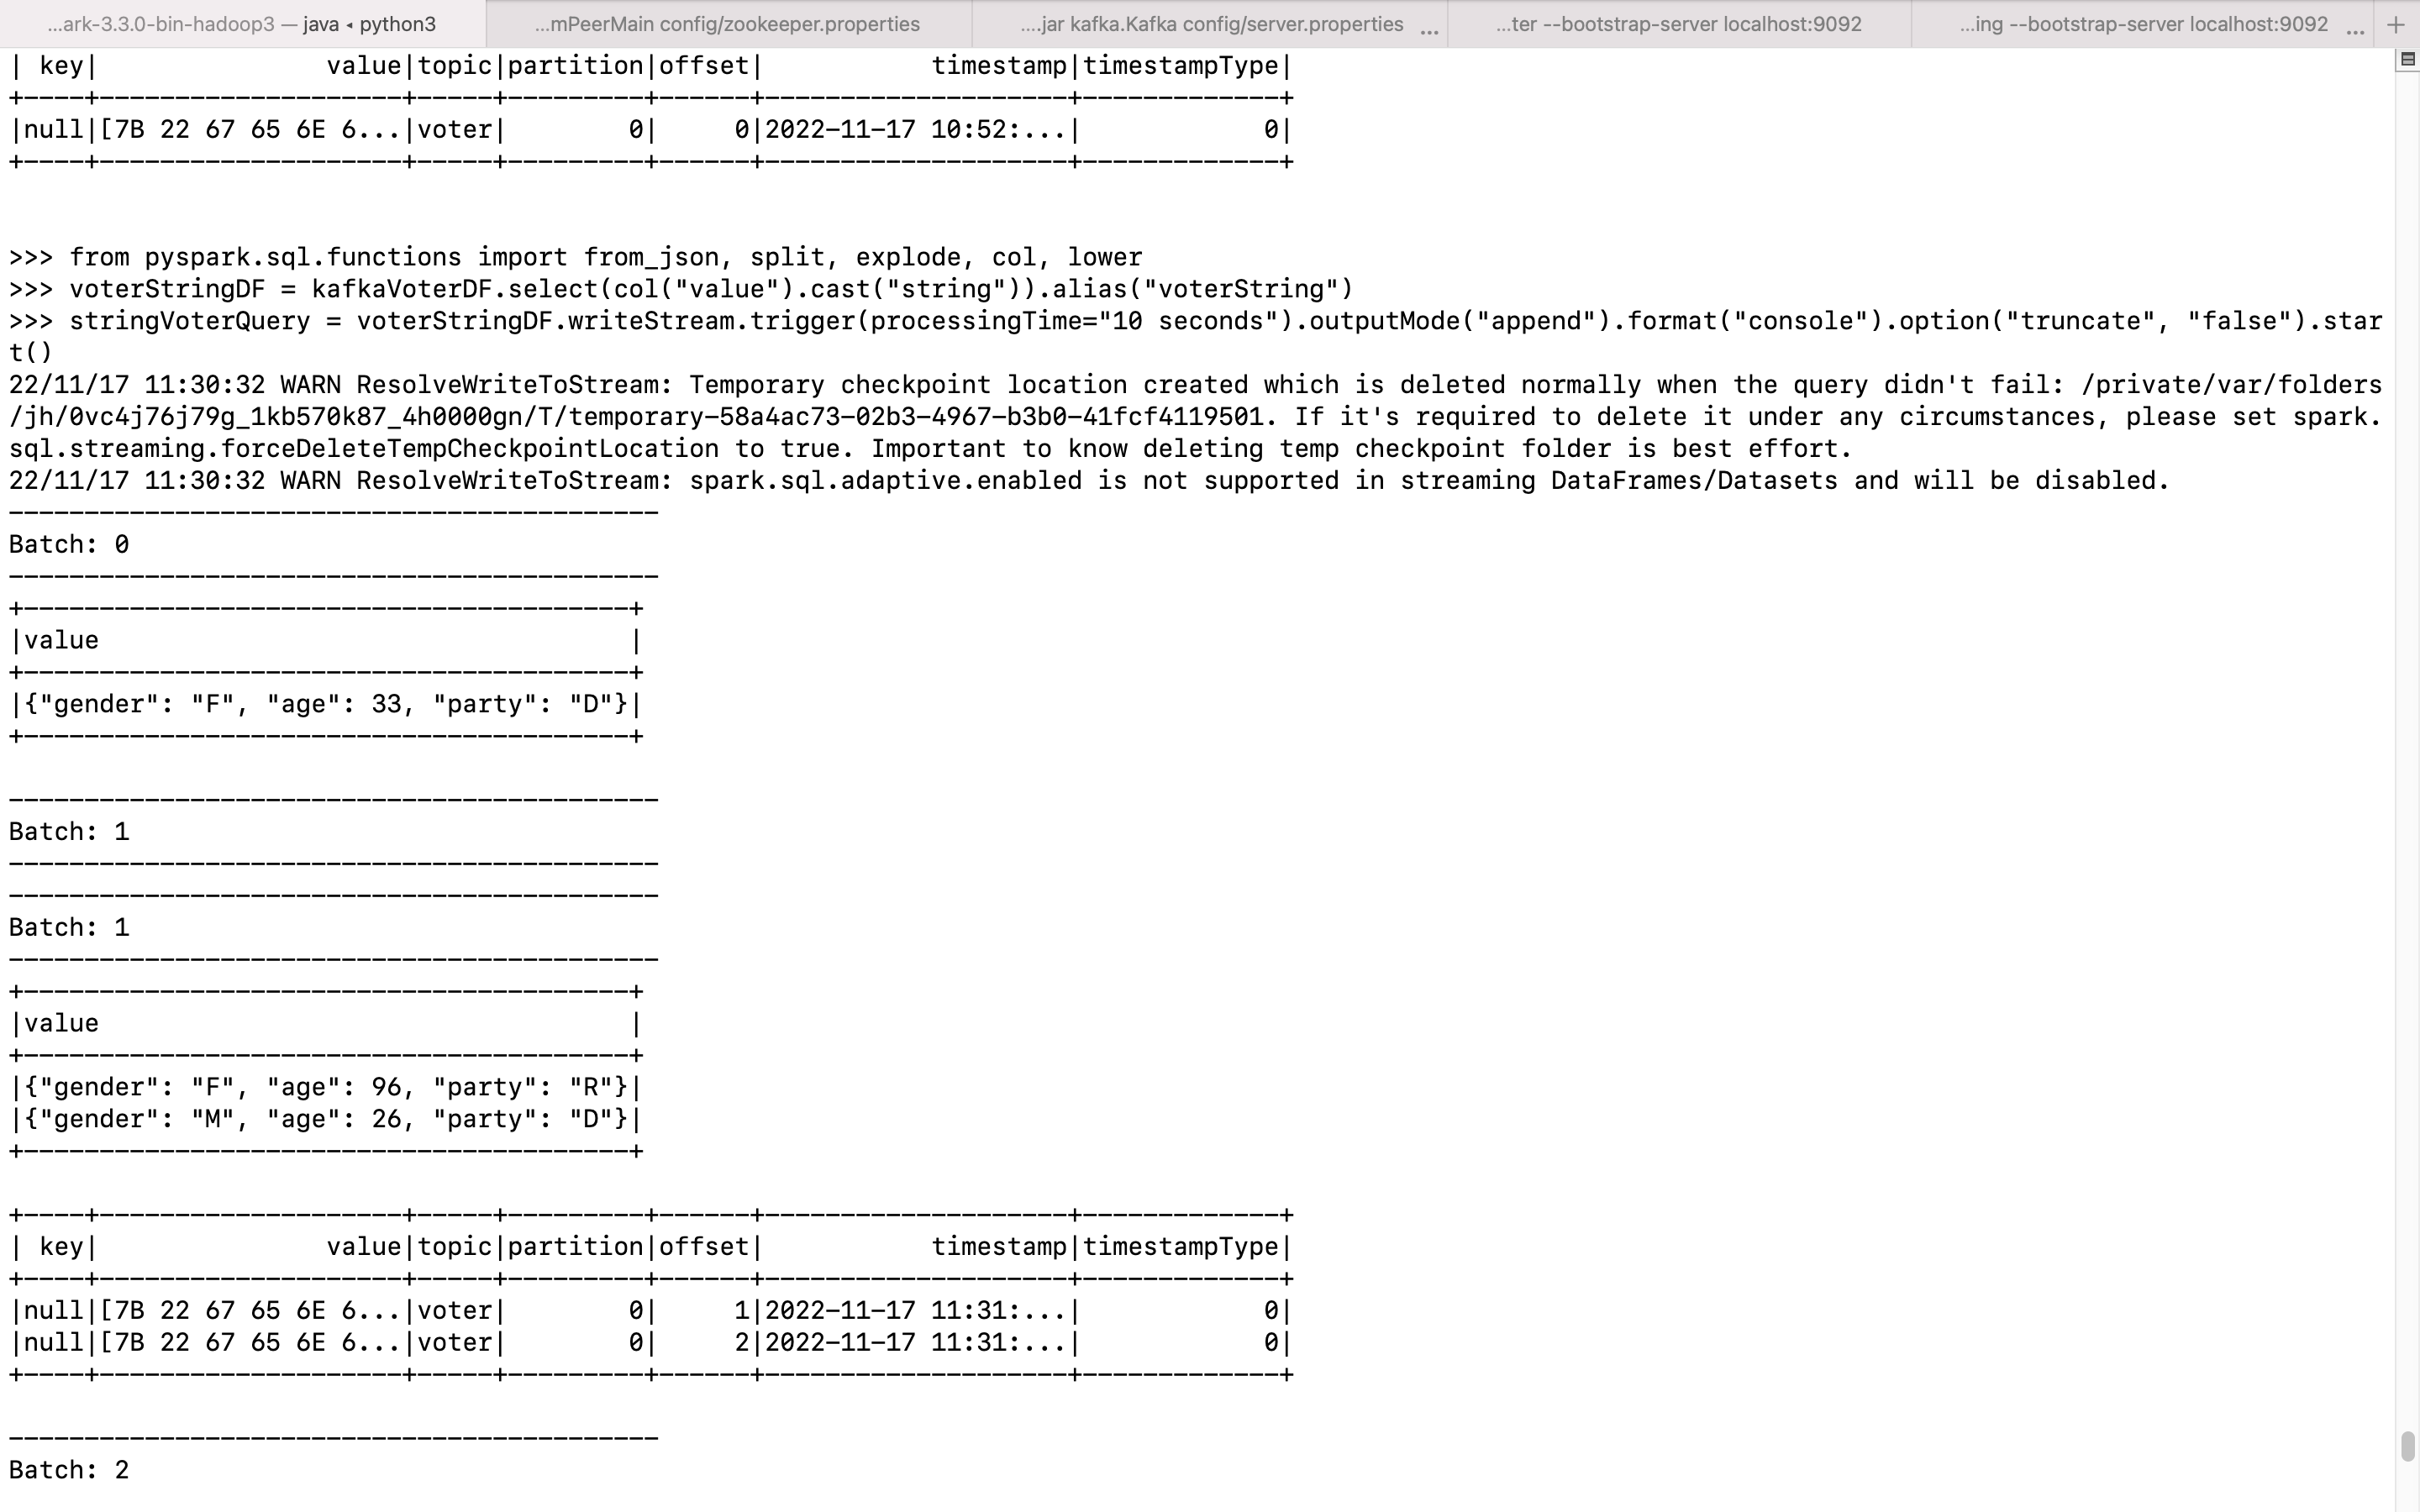

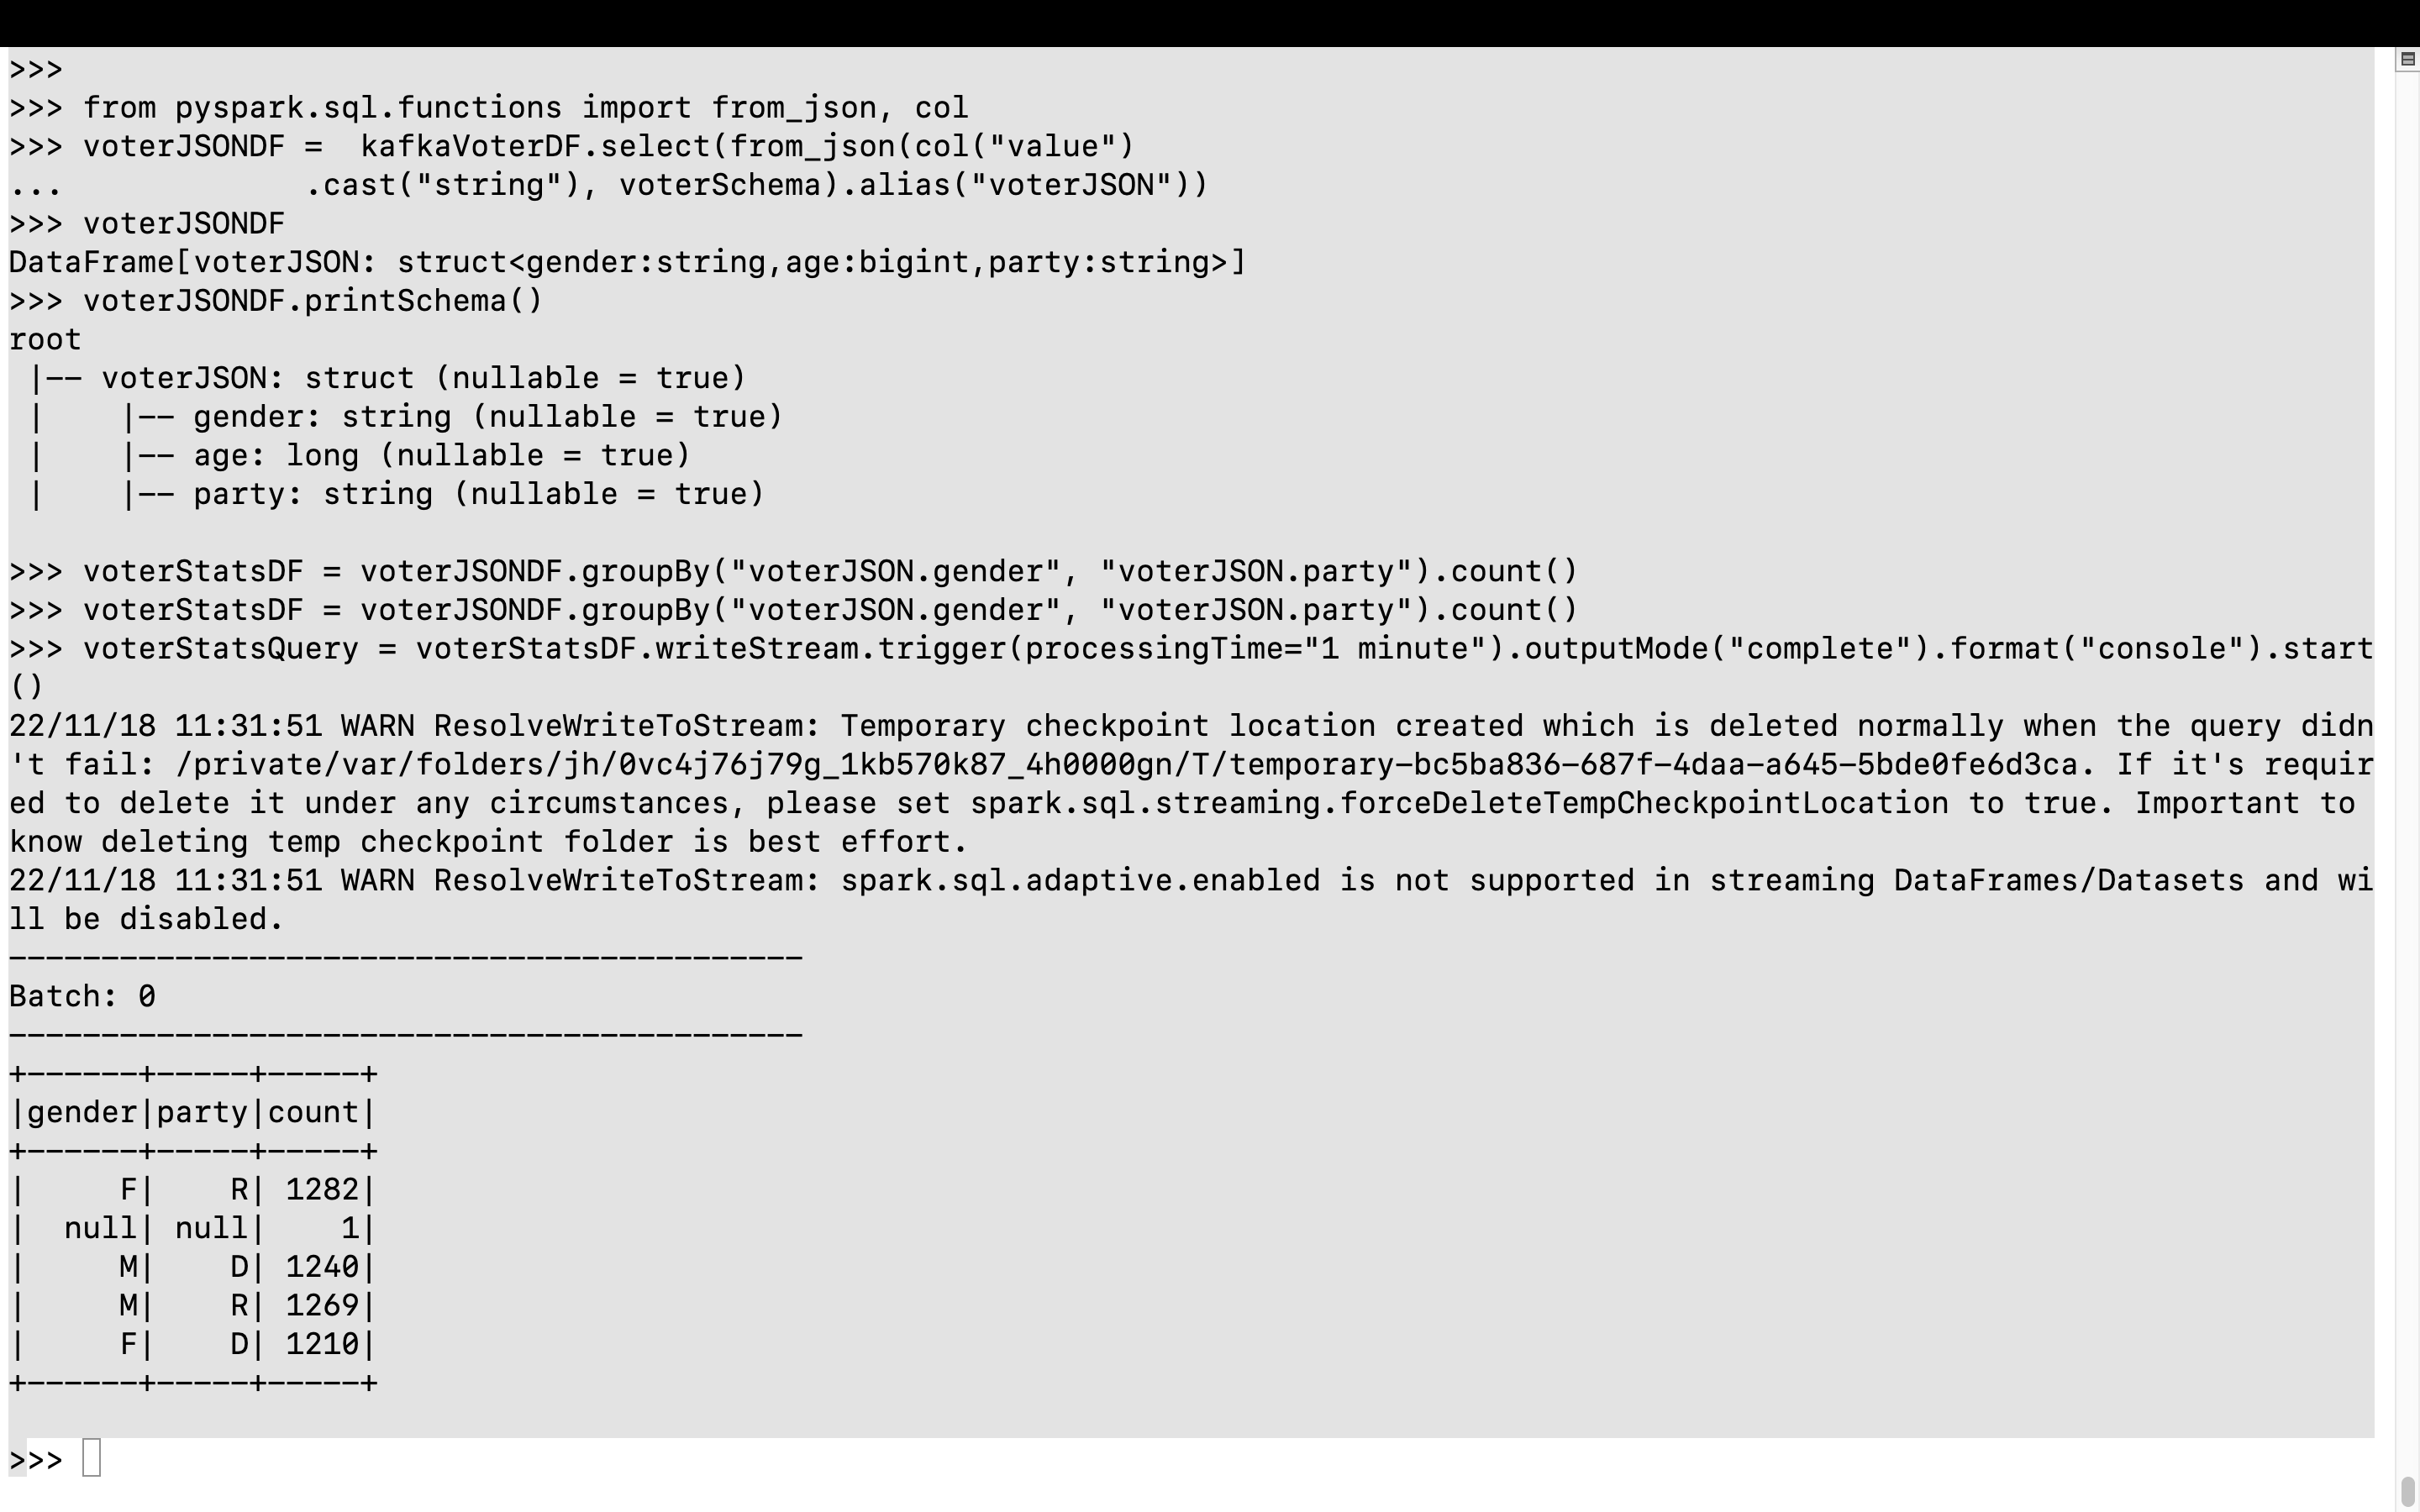

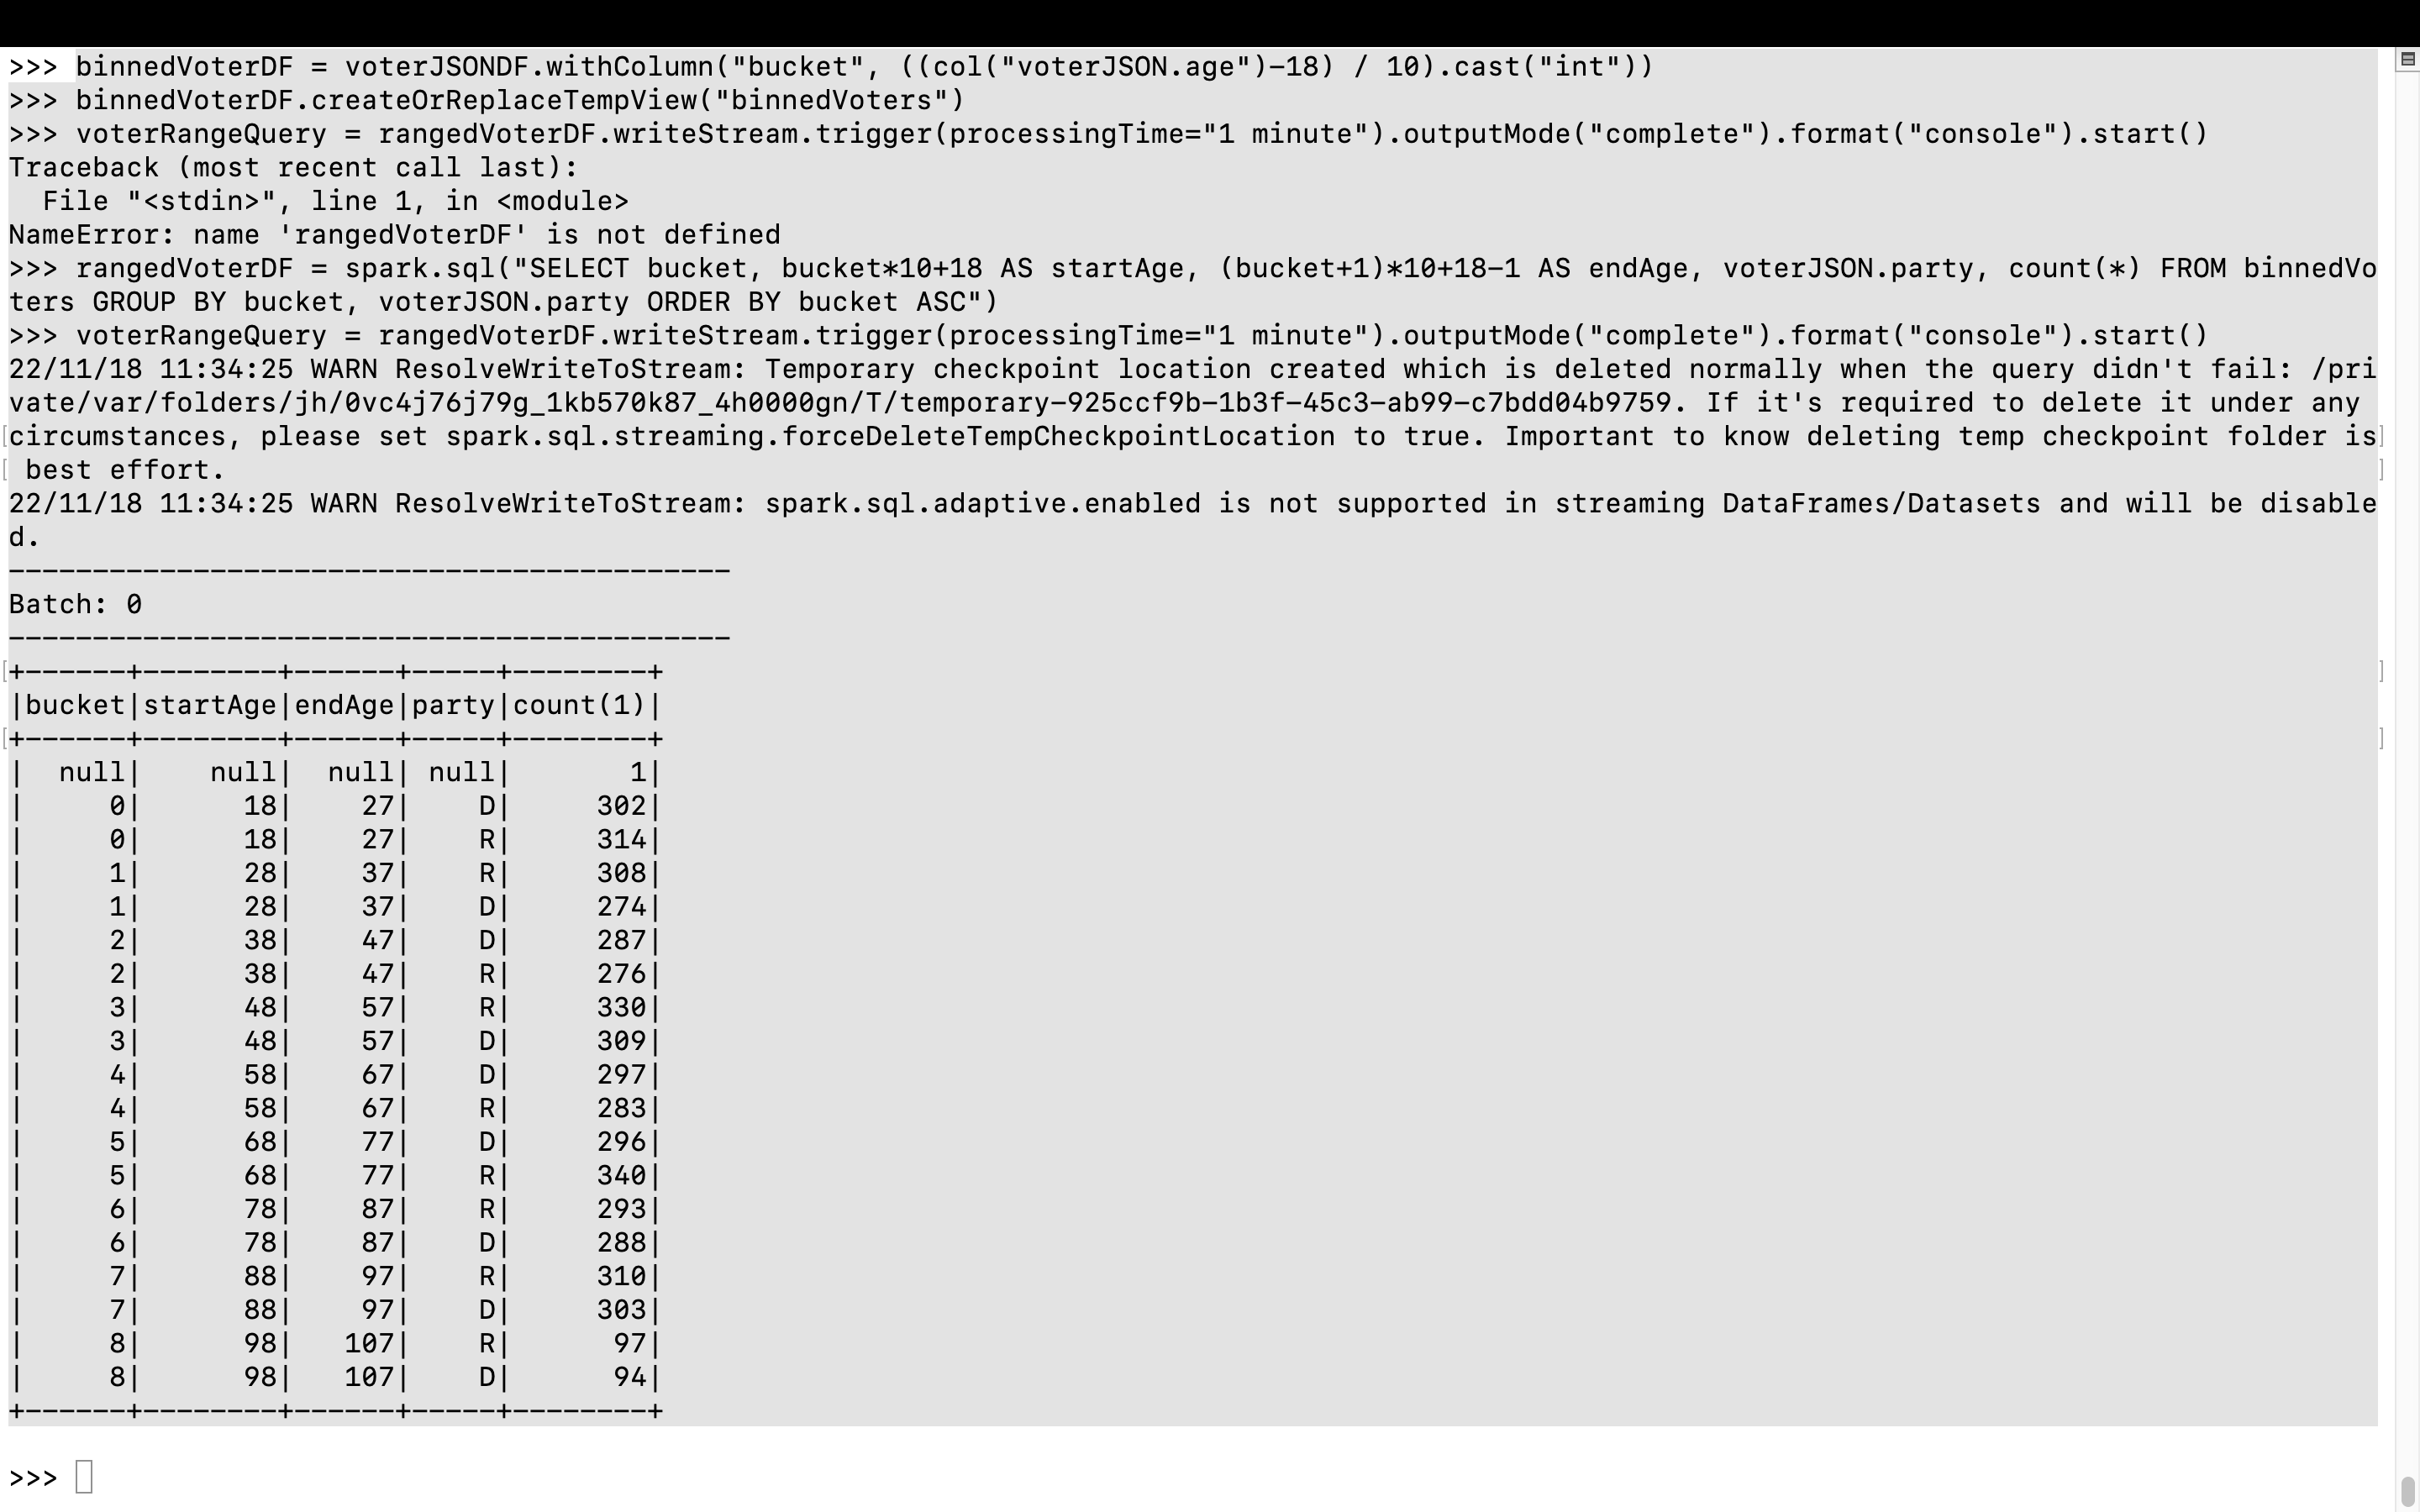

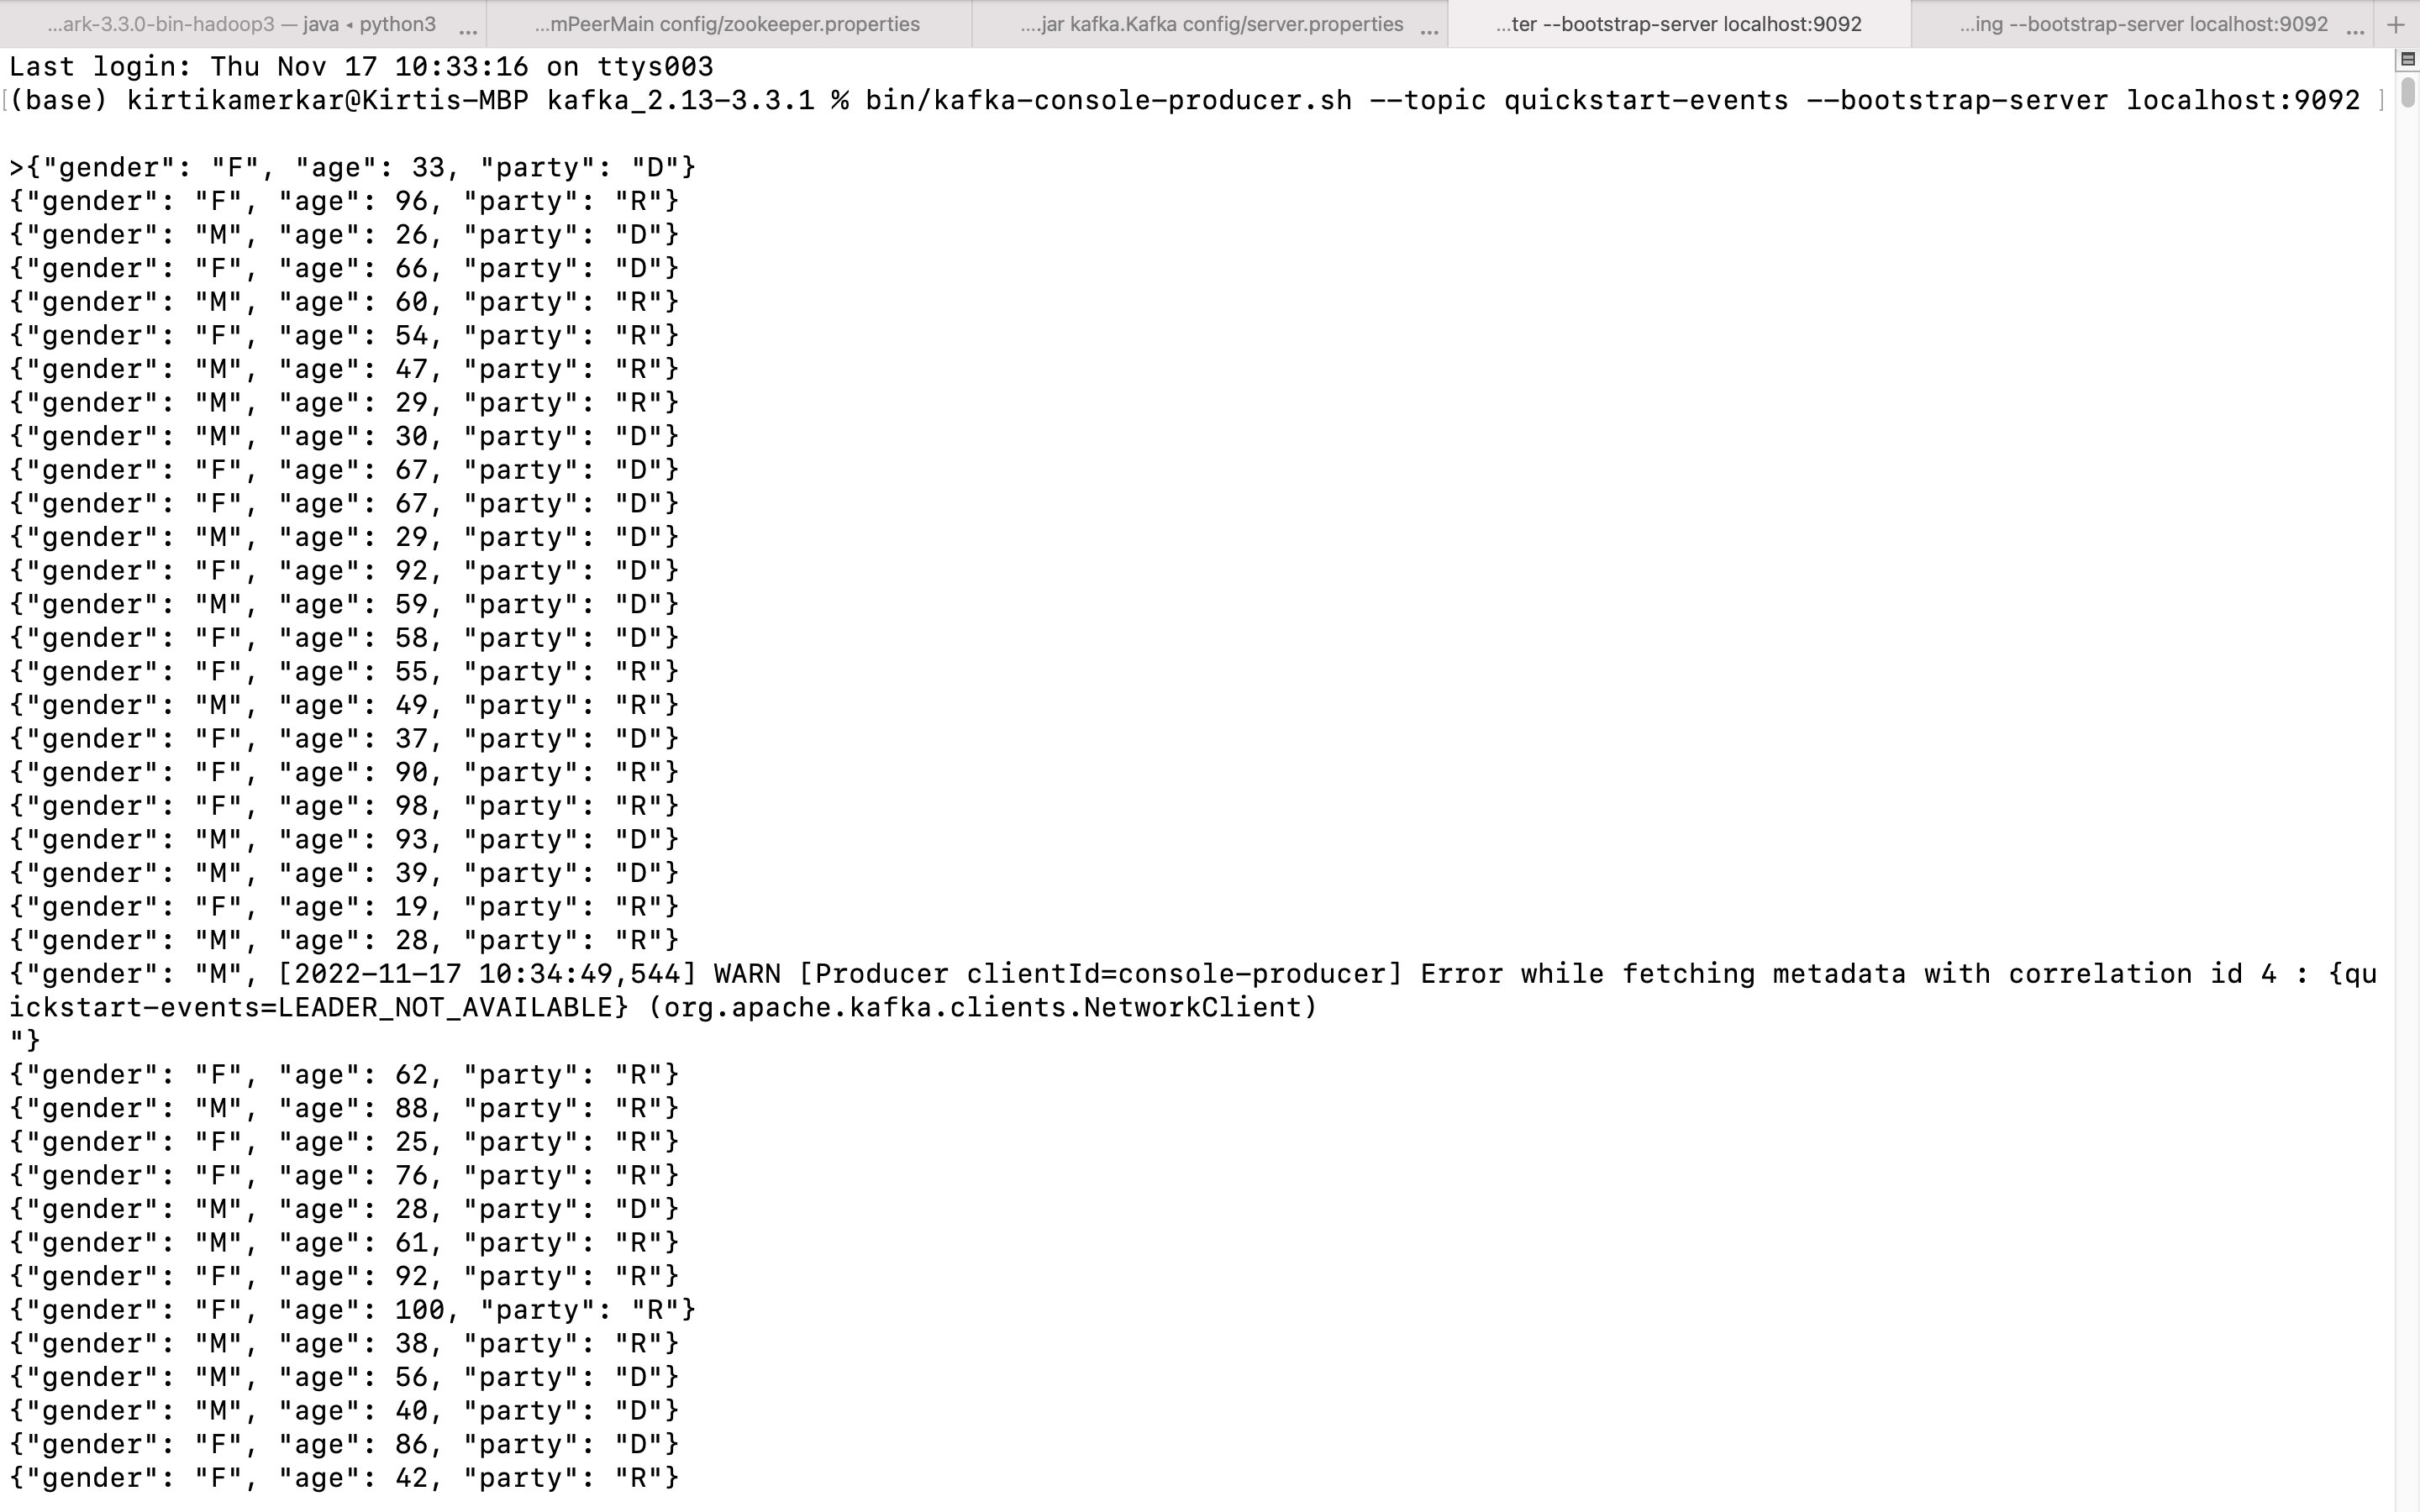

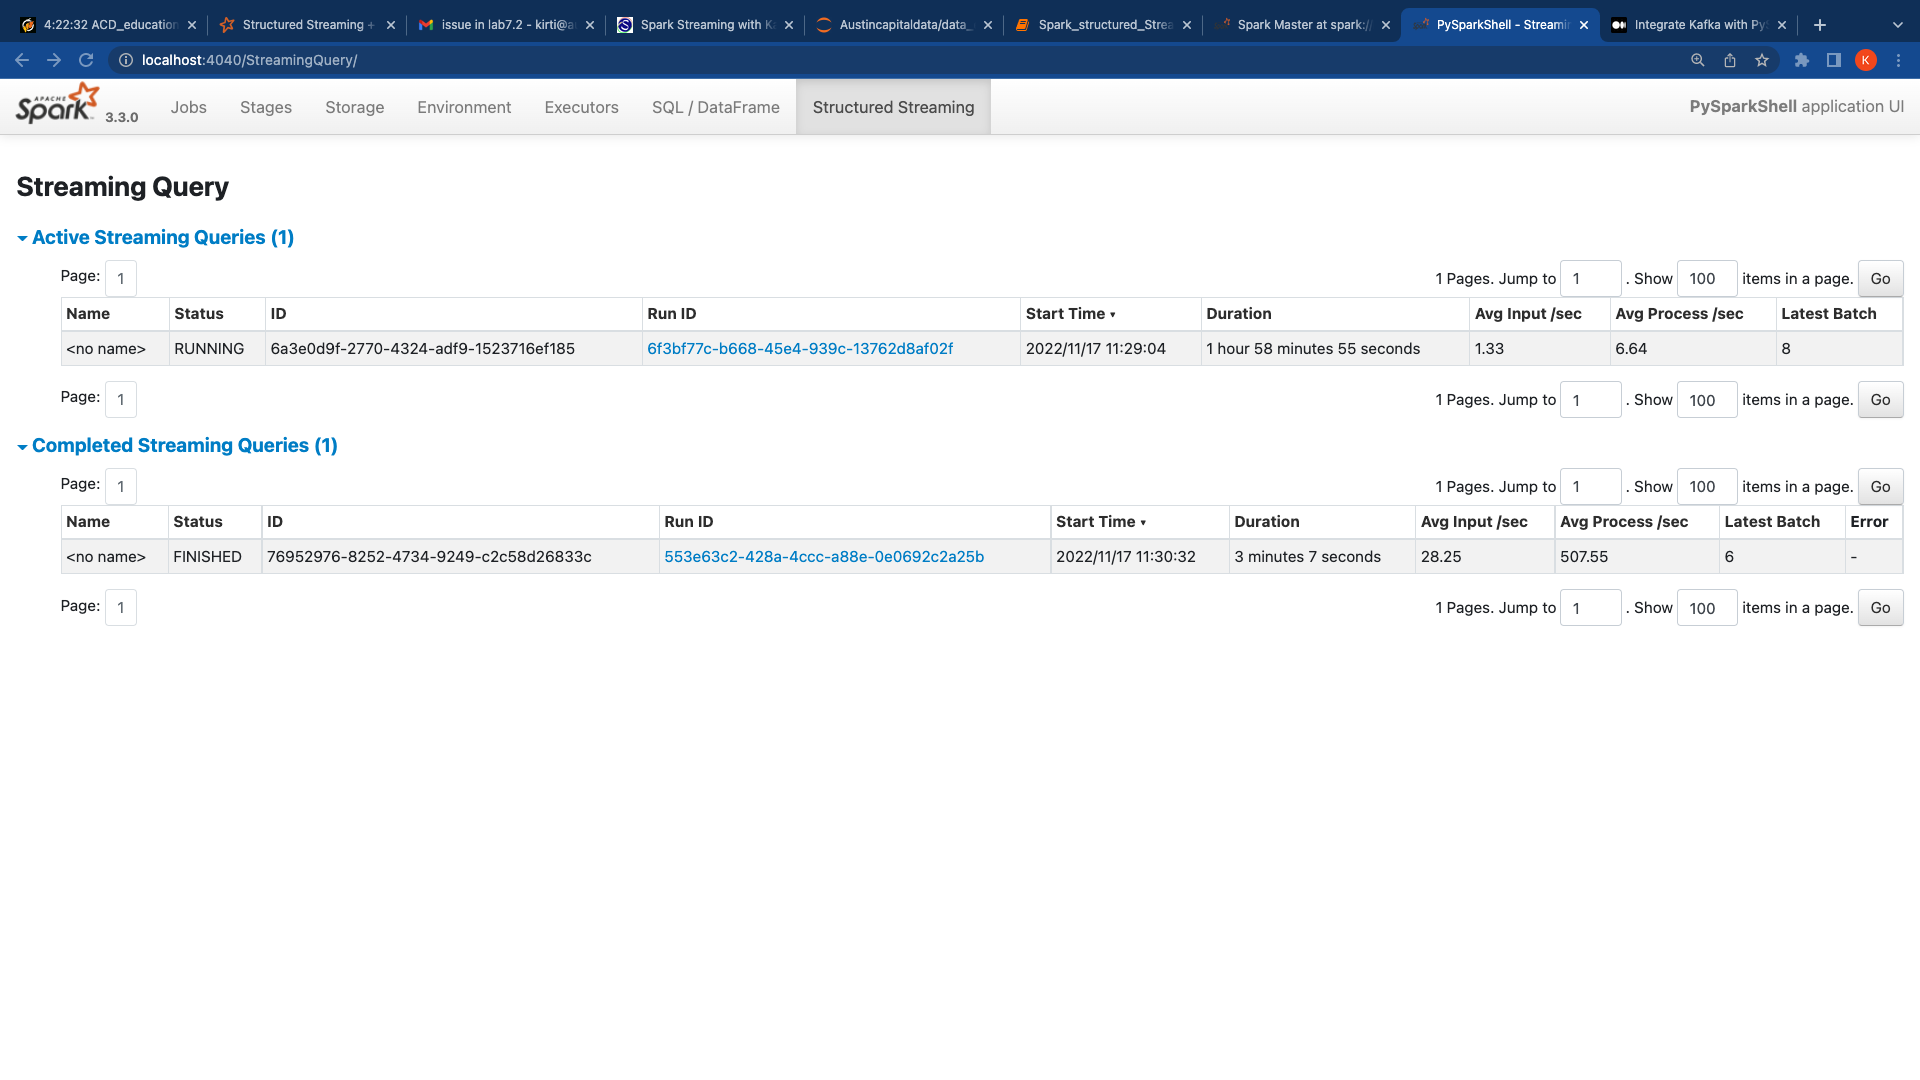

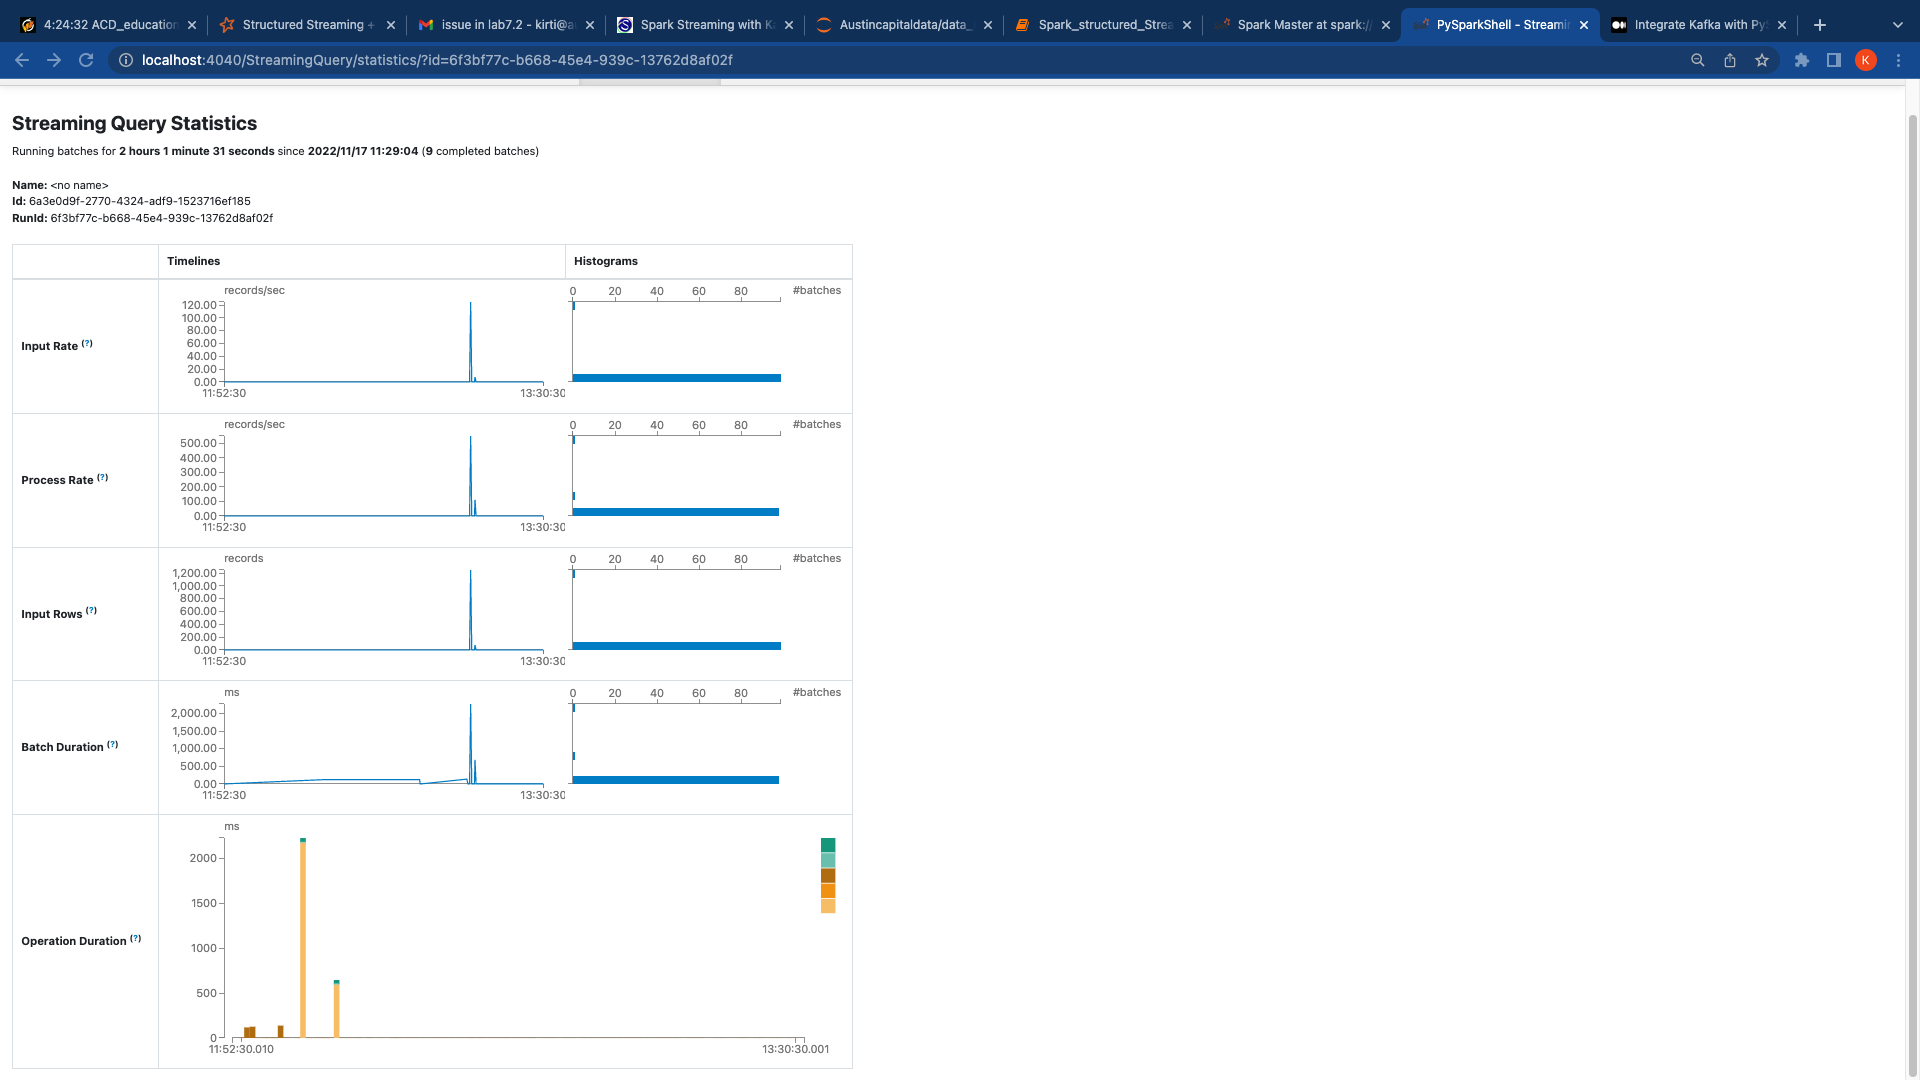

##### Creating Bucket:
- Data Bucket:
  - Buckets can simply be groups of partitions. A bucket can be composed by a certain number of partitions and, depending on this number, will express its size. 
  - For example, a topic with six partitions could be broken down into four partitions for a bucket with a higher priority and two partitions for a bucket with less priority. But what if someone increases the number of partitions in the topic? This would force us to stop the execution of our producers and consumers, make the change in the configuration, and then re-execute them again.
  - Captures/Buffers incoming data 
  - Choices: Kafka, MQ, Amazon Kinesis, ...
-  Process: Low latency processing – Choices: Spark, Storm, Flink, ...
-  Store: Store data - often in NoSQL store – NoSQL Storage: HBase, Cassandra ..
- We first create an age bucket
  - An extra column that spans 10 years  
  - Then we group the data by the buckets
  -  binnedVoterDF = voterJSONDF
     .withColumn("bucket", ((col("voterJSON.age")-18) / 10).cast("int"))
- Create data grouped by bucket - done in SQL which is a bit easier
  - binnedVoterDF.createOrReplaceTempView("binnedVoters")
  - rangedVoterDF = spark.sql("SELECT bucket, bucket*10+18 AS startAge, (bucket+1)*10+18-1 AS endAge, voterJSON.party, count(*) FROM binnedVoters GROUP BY bucket, voterJSON.party ORDER BY bucket ASC")
        

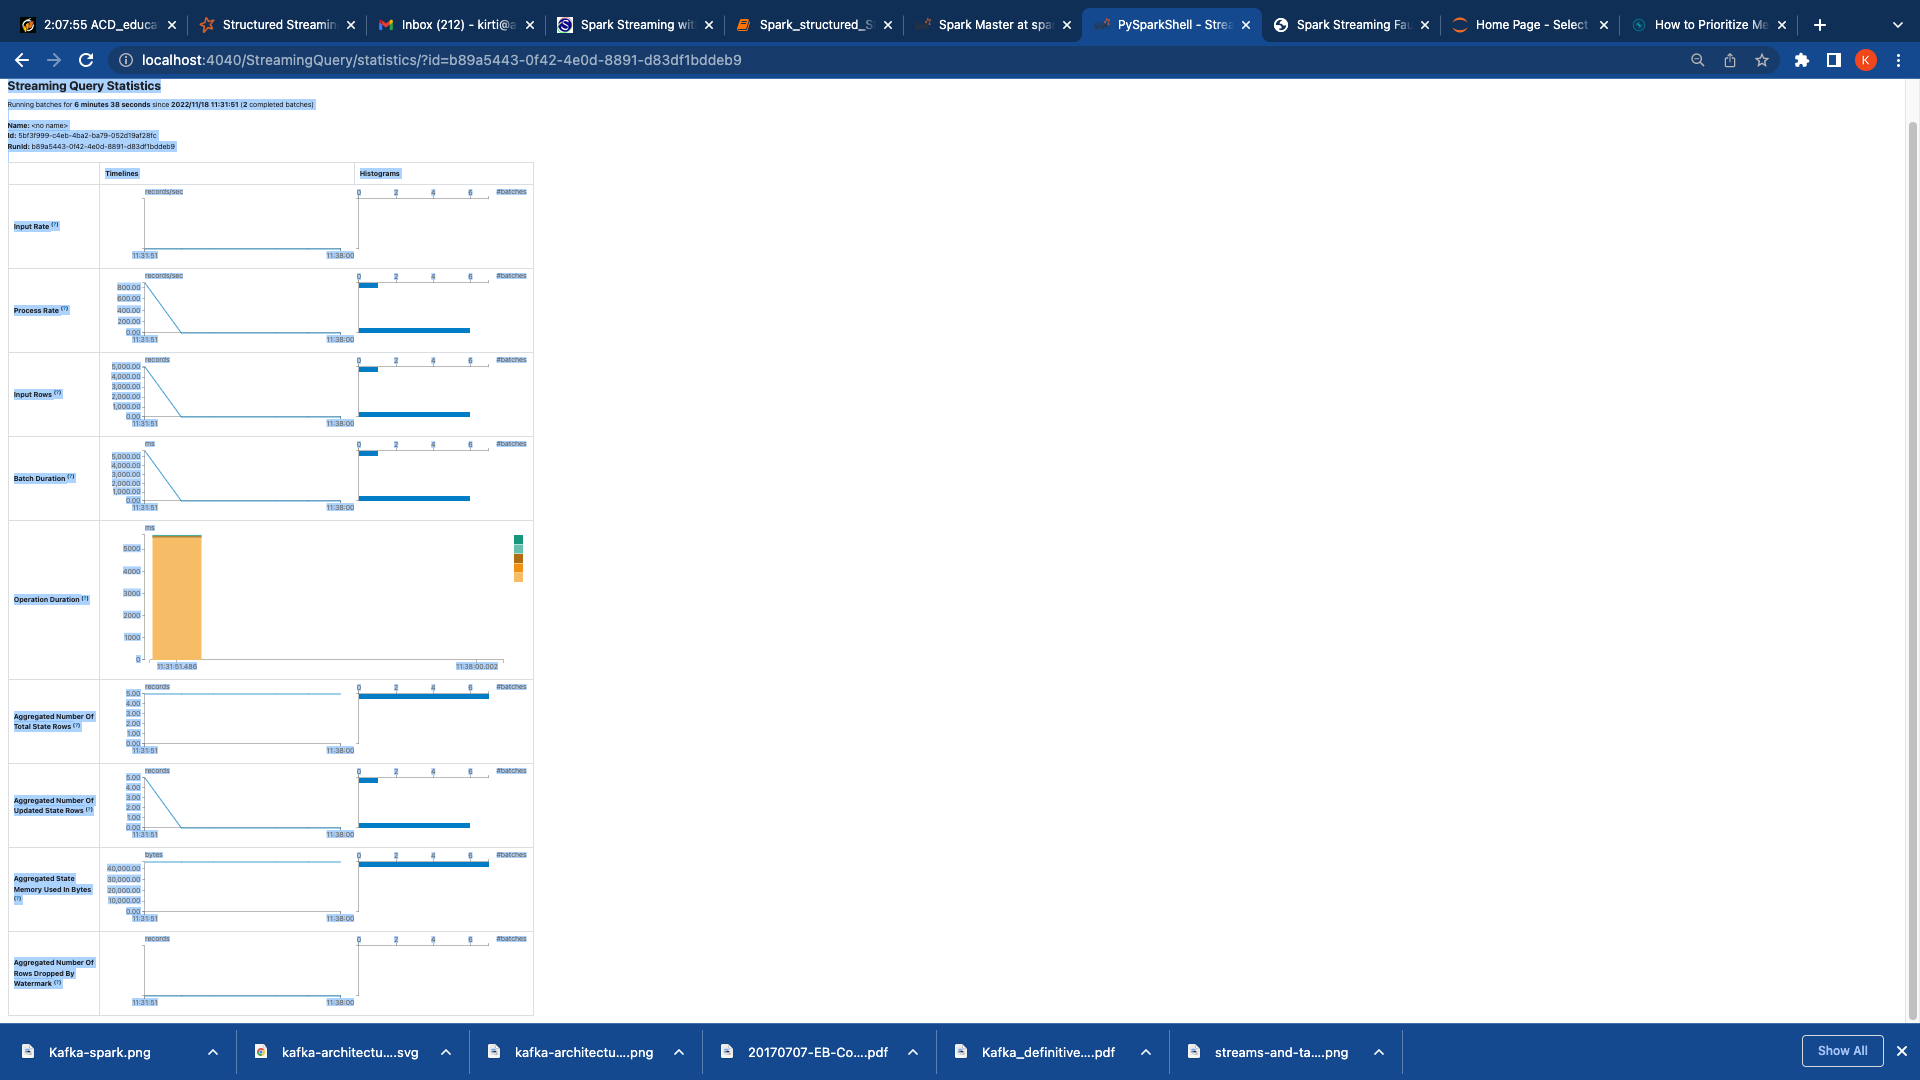

##### Window Operations for Streaming
- ###### What is windowing?
  - The simplest windowing function is a window, which lets you create a new DStream, computed by applying the windowing parameters to the old DStream. You can use any of the DStream operations on the new stream, so you get all the flexibility you want.
  - Windowed computations allow you to apply transformations over a sliding window of data. Any window operation needs to specify two parameters:
    - window length
      - The duration of the window in secs
    - sliding interval
      - The interval at which the window operation is performed in secs
These parameters must be multiples of the batch interval
- ##### Windowing with Kafka
  - 

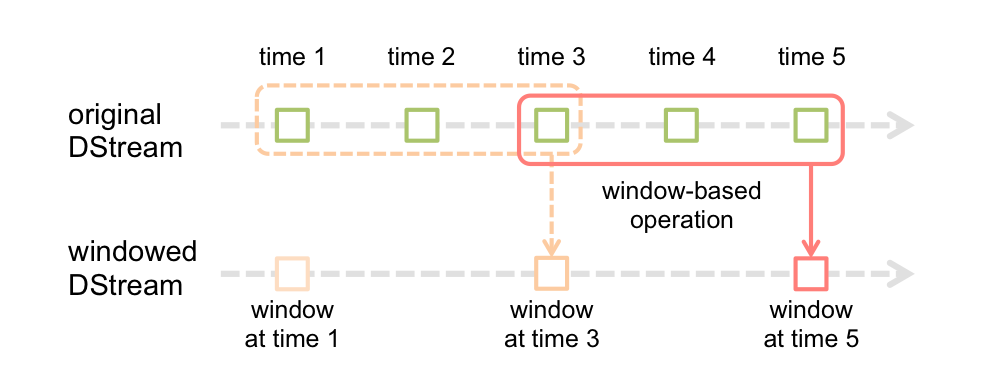

In [ ]:
linesDF=spark.readStream.format("Socket").option("host","localhost").option("port","9999").load()

# Split the lines into words
splitWordsDF = linesDF.select(explode (split(col("value"), "\\s+"))
   .alias("word")).select(lower(col("word")).alias("word"))
# Create DataFrame with schema [word: string, timestamp: timestamp]
timeStampedWordsDF = splitWordsDF.withColumn("current_timestamp", current_timestamp())
# Create windowed DF
windowedWordCountsDF = timeStampedWordsDF.groupBy(
window(timeStampedWordsDF.current_timestamp, "30 seconds","15 seconds"),timeStampedWordsDF.word).count().orderBy("window")
windowQuery=windowedWordCountsDF.writeStream.format("console").outputMode("complete").option("truncate", "false").start().awaitTermination()

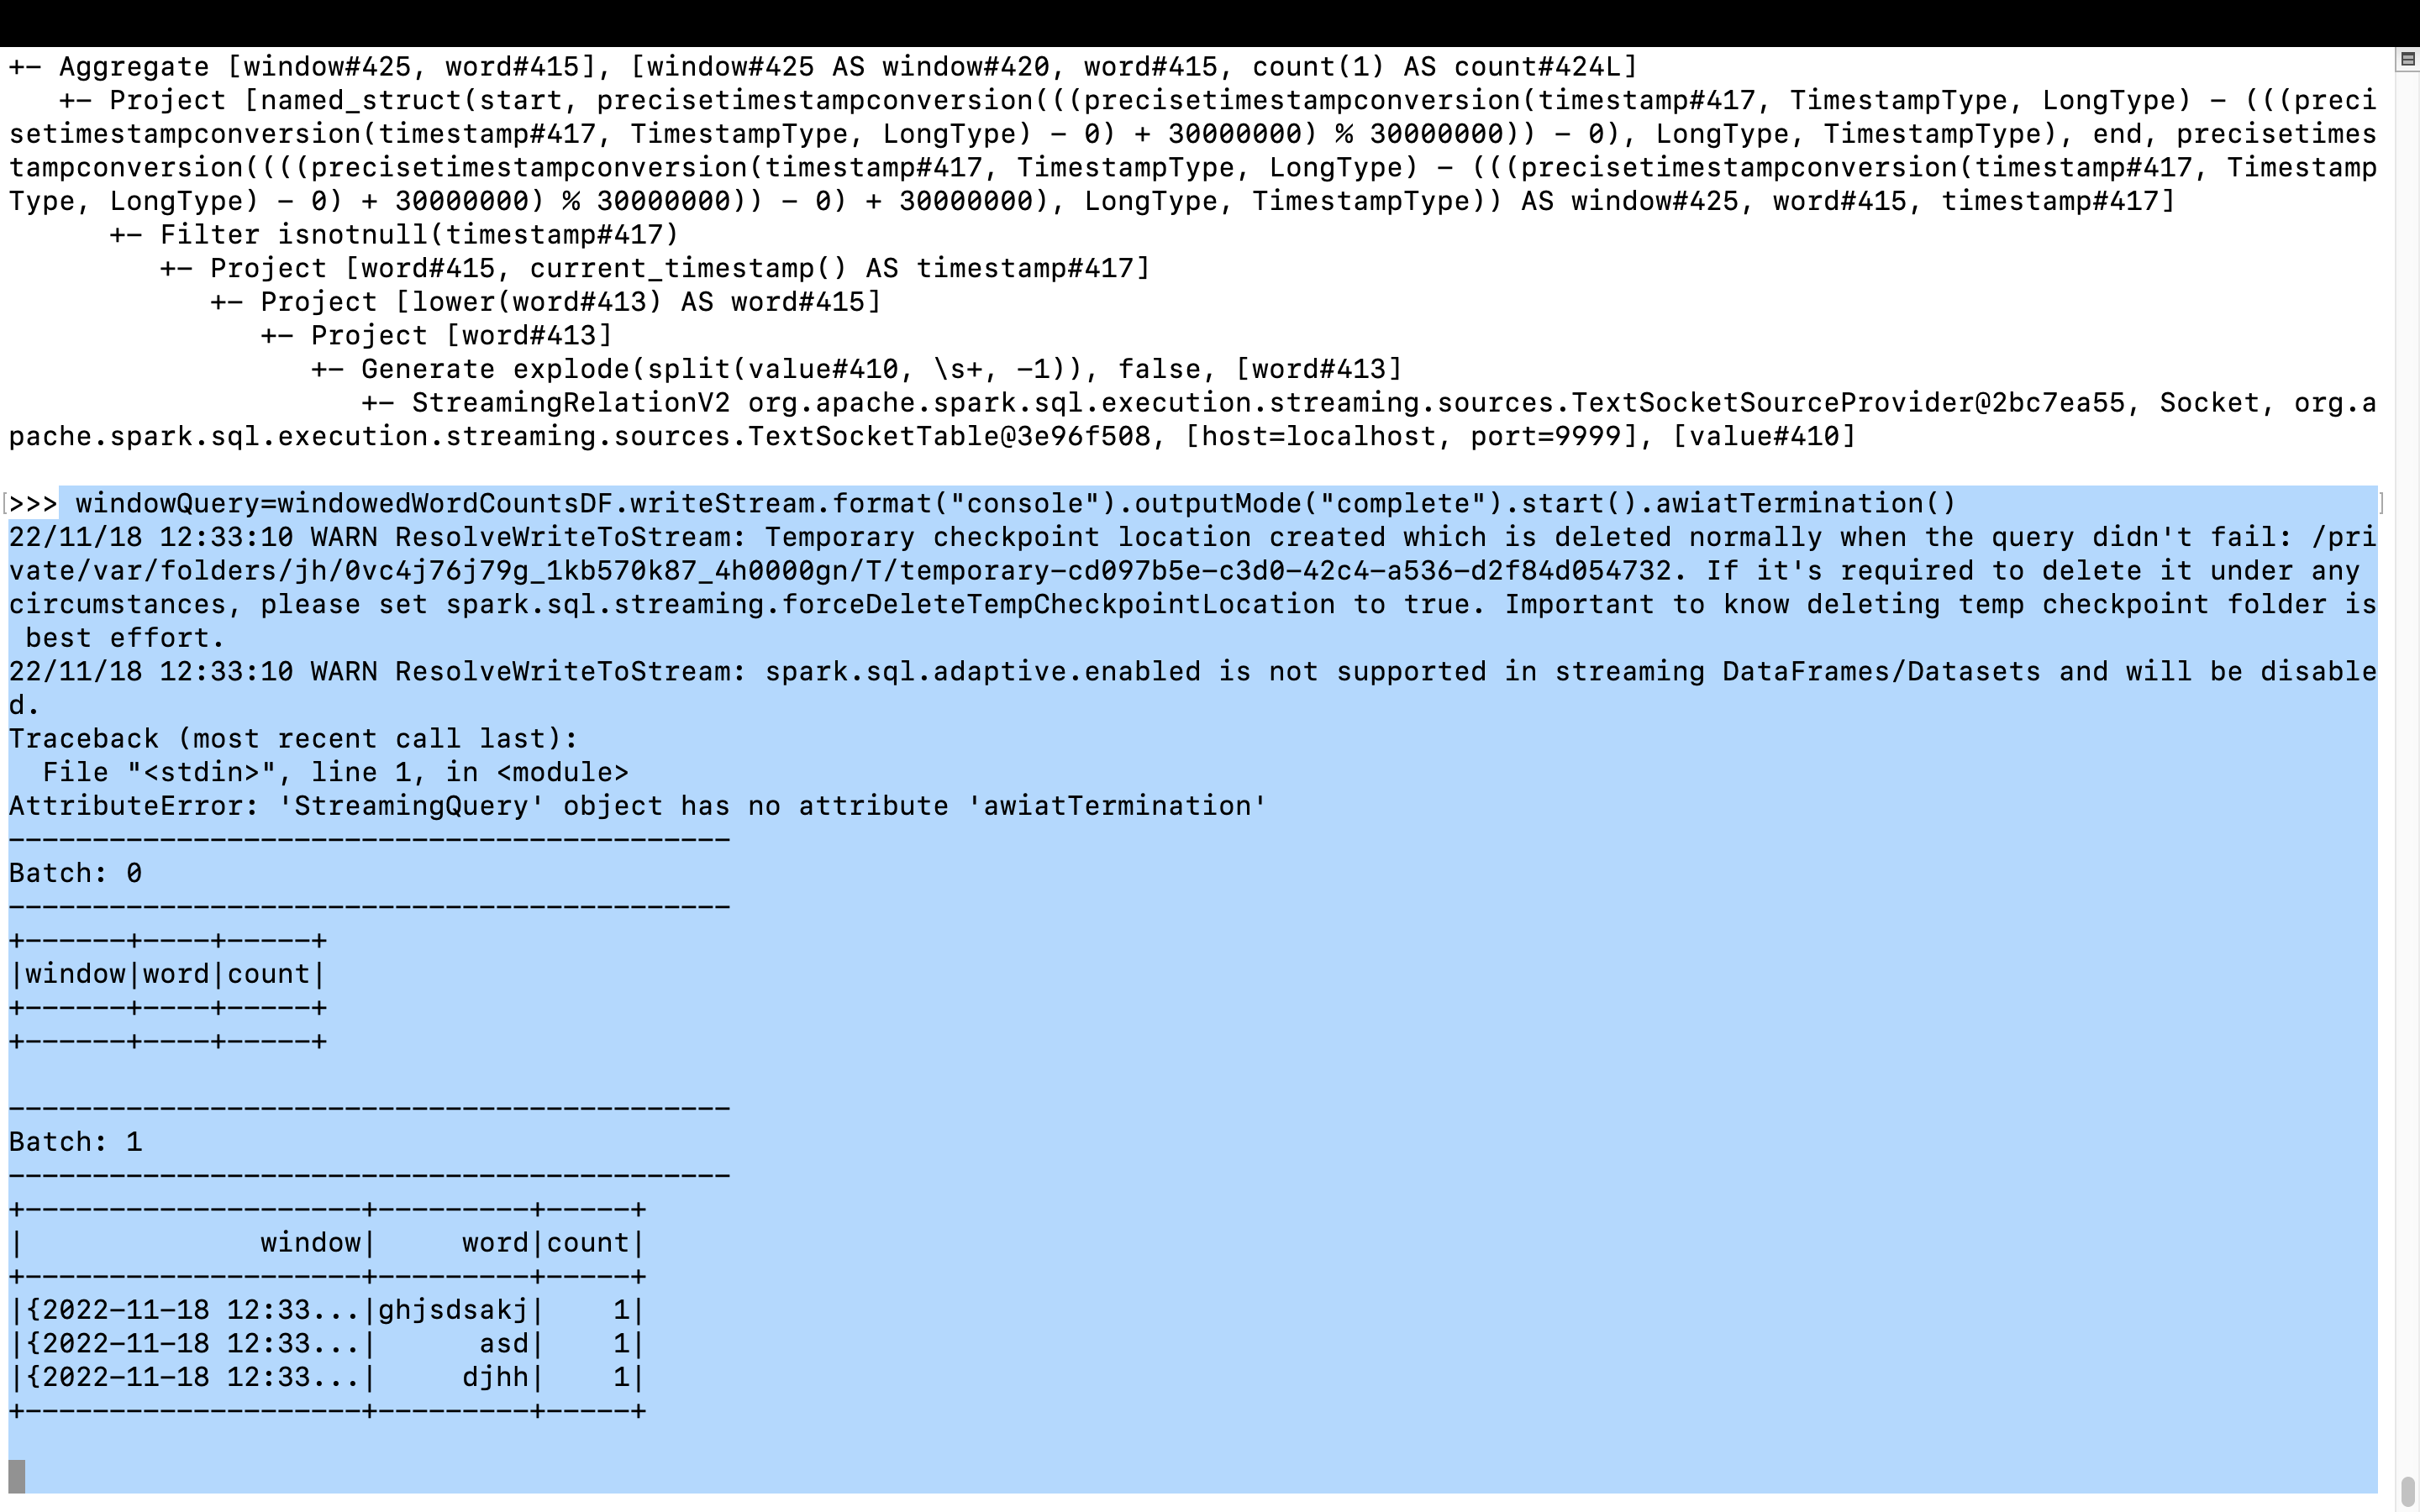

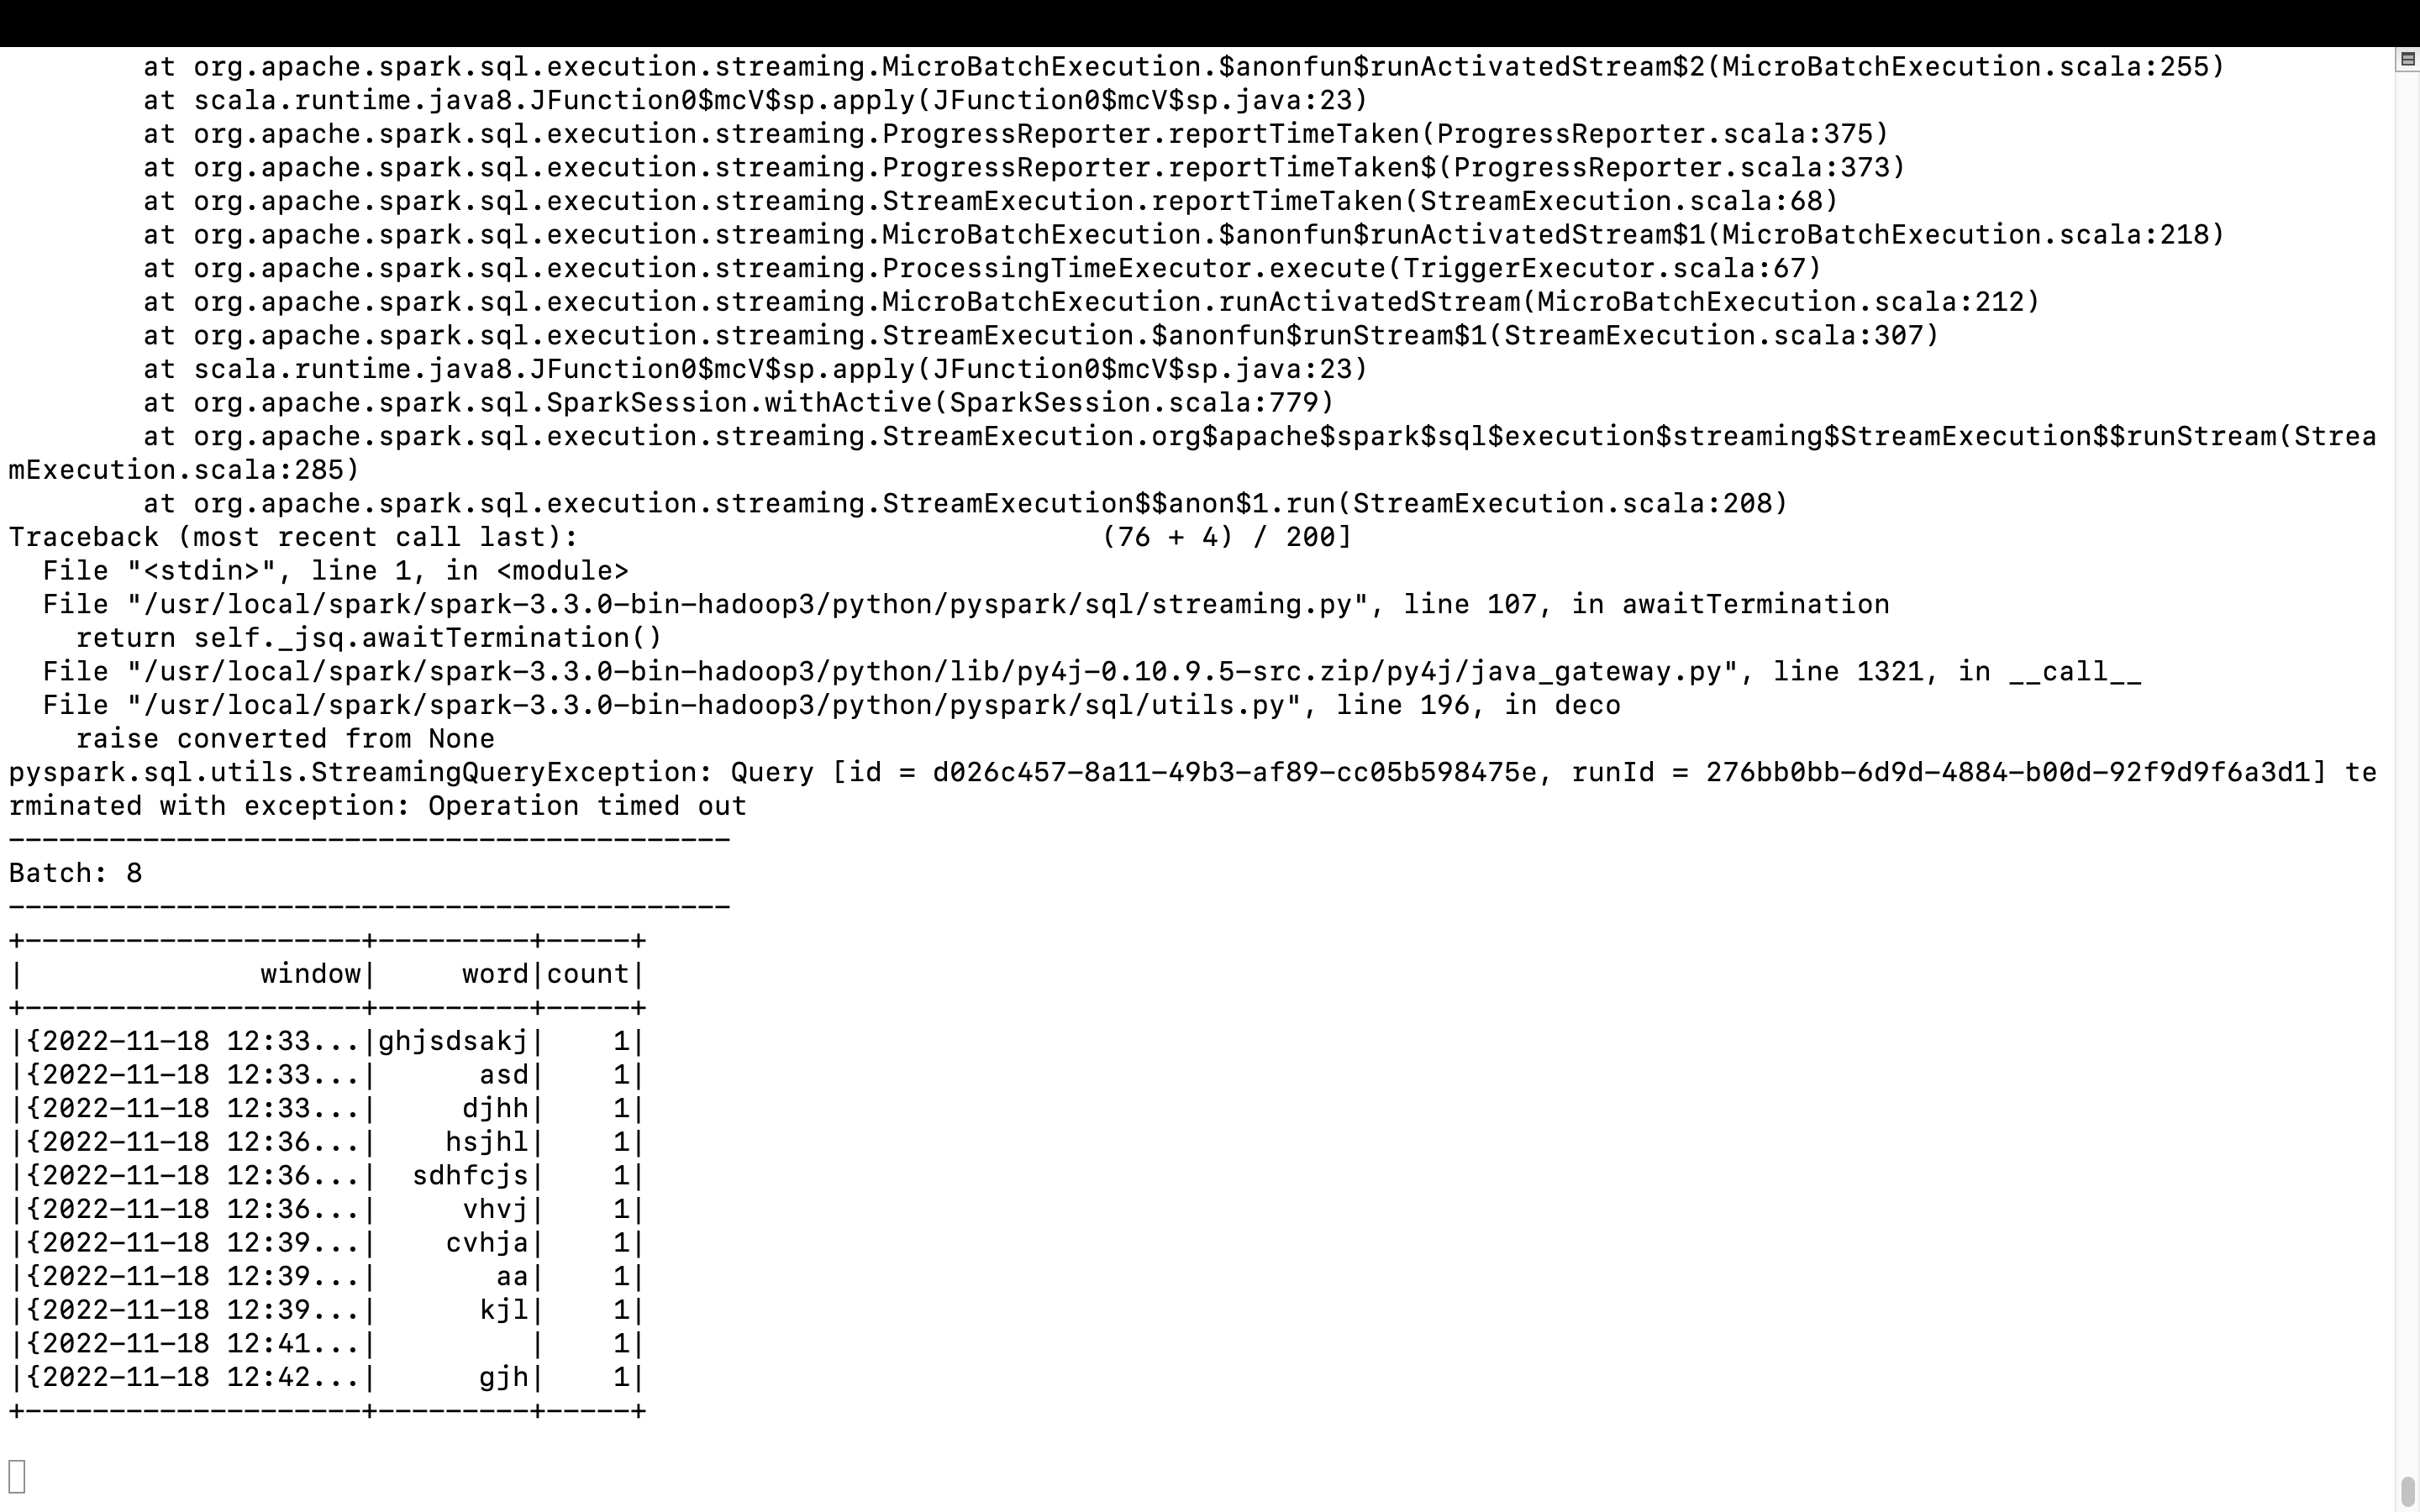

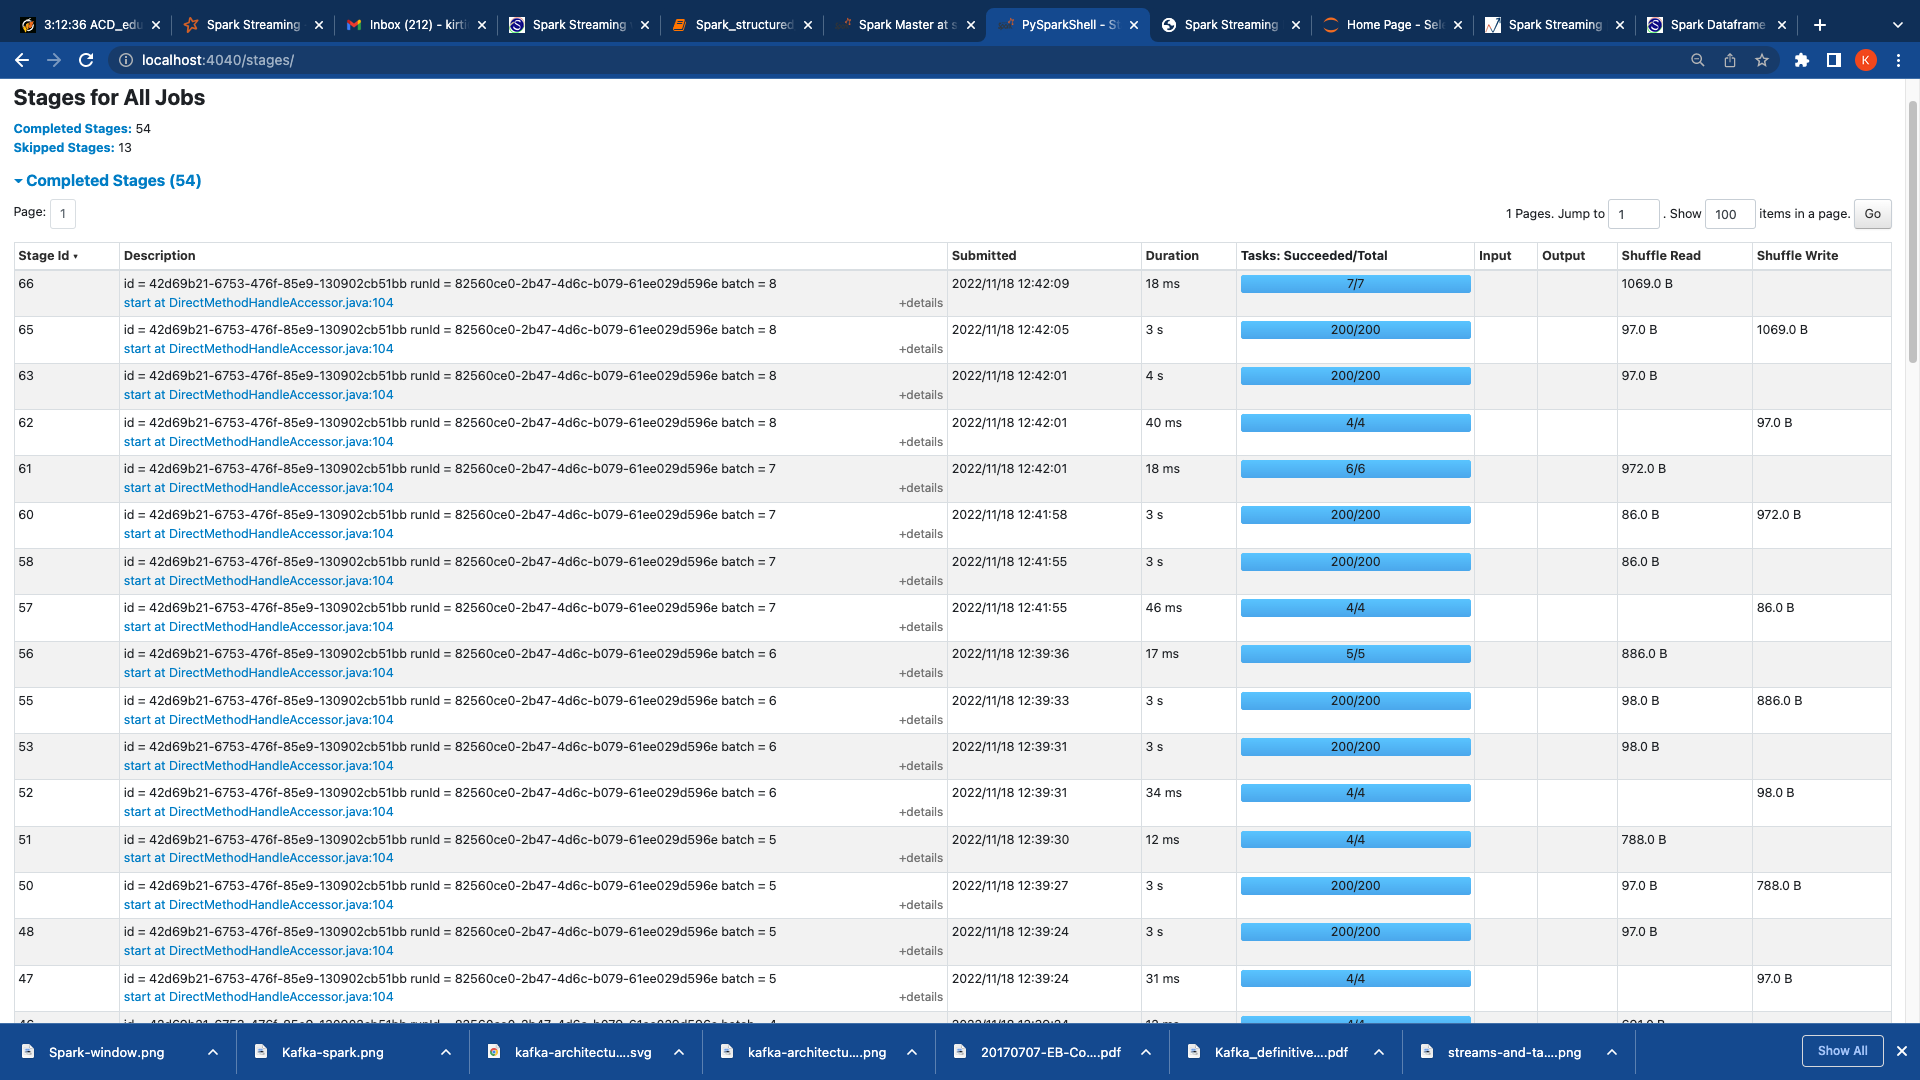

In [ ]:
#create schema for windowing
voterWindowSchema = StructType().add("gender",StringType())\
.add("age",LongType()).add("party",StringType()) .add("timestamp", TimestampType())
#Ingest as JSON
voterWindowJSONDF = kafkaVoterDF.select(from_json(col("value")\
     .cast("string"), voterWindowSchema).alias("voterJSON"))

windowedVoterStatsDF = voterWindowJSONDF\
.groupBy(window(voterWindowJSONDF.voterJSON.timestamp, "10 minutes", "5 minutes"),voterWindowJSONDF.voterJSON.gender, voterJSONDF.voterJSON.party)\
.count()\
.orderBy("window")
windowVoterQuery=windowedVoterStatsDF.writStream.format("console").trigger(processingTime="1 minute").outputMode("complete").start()

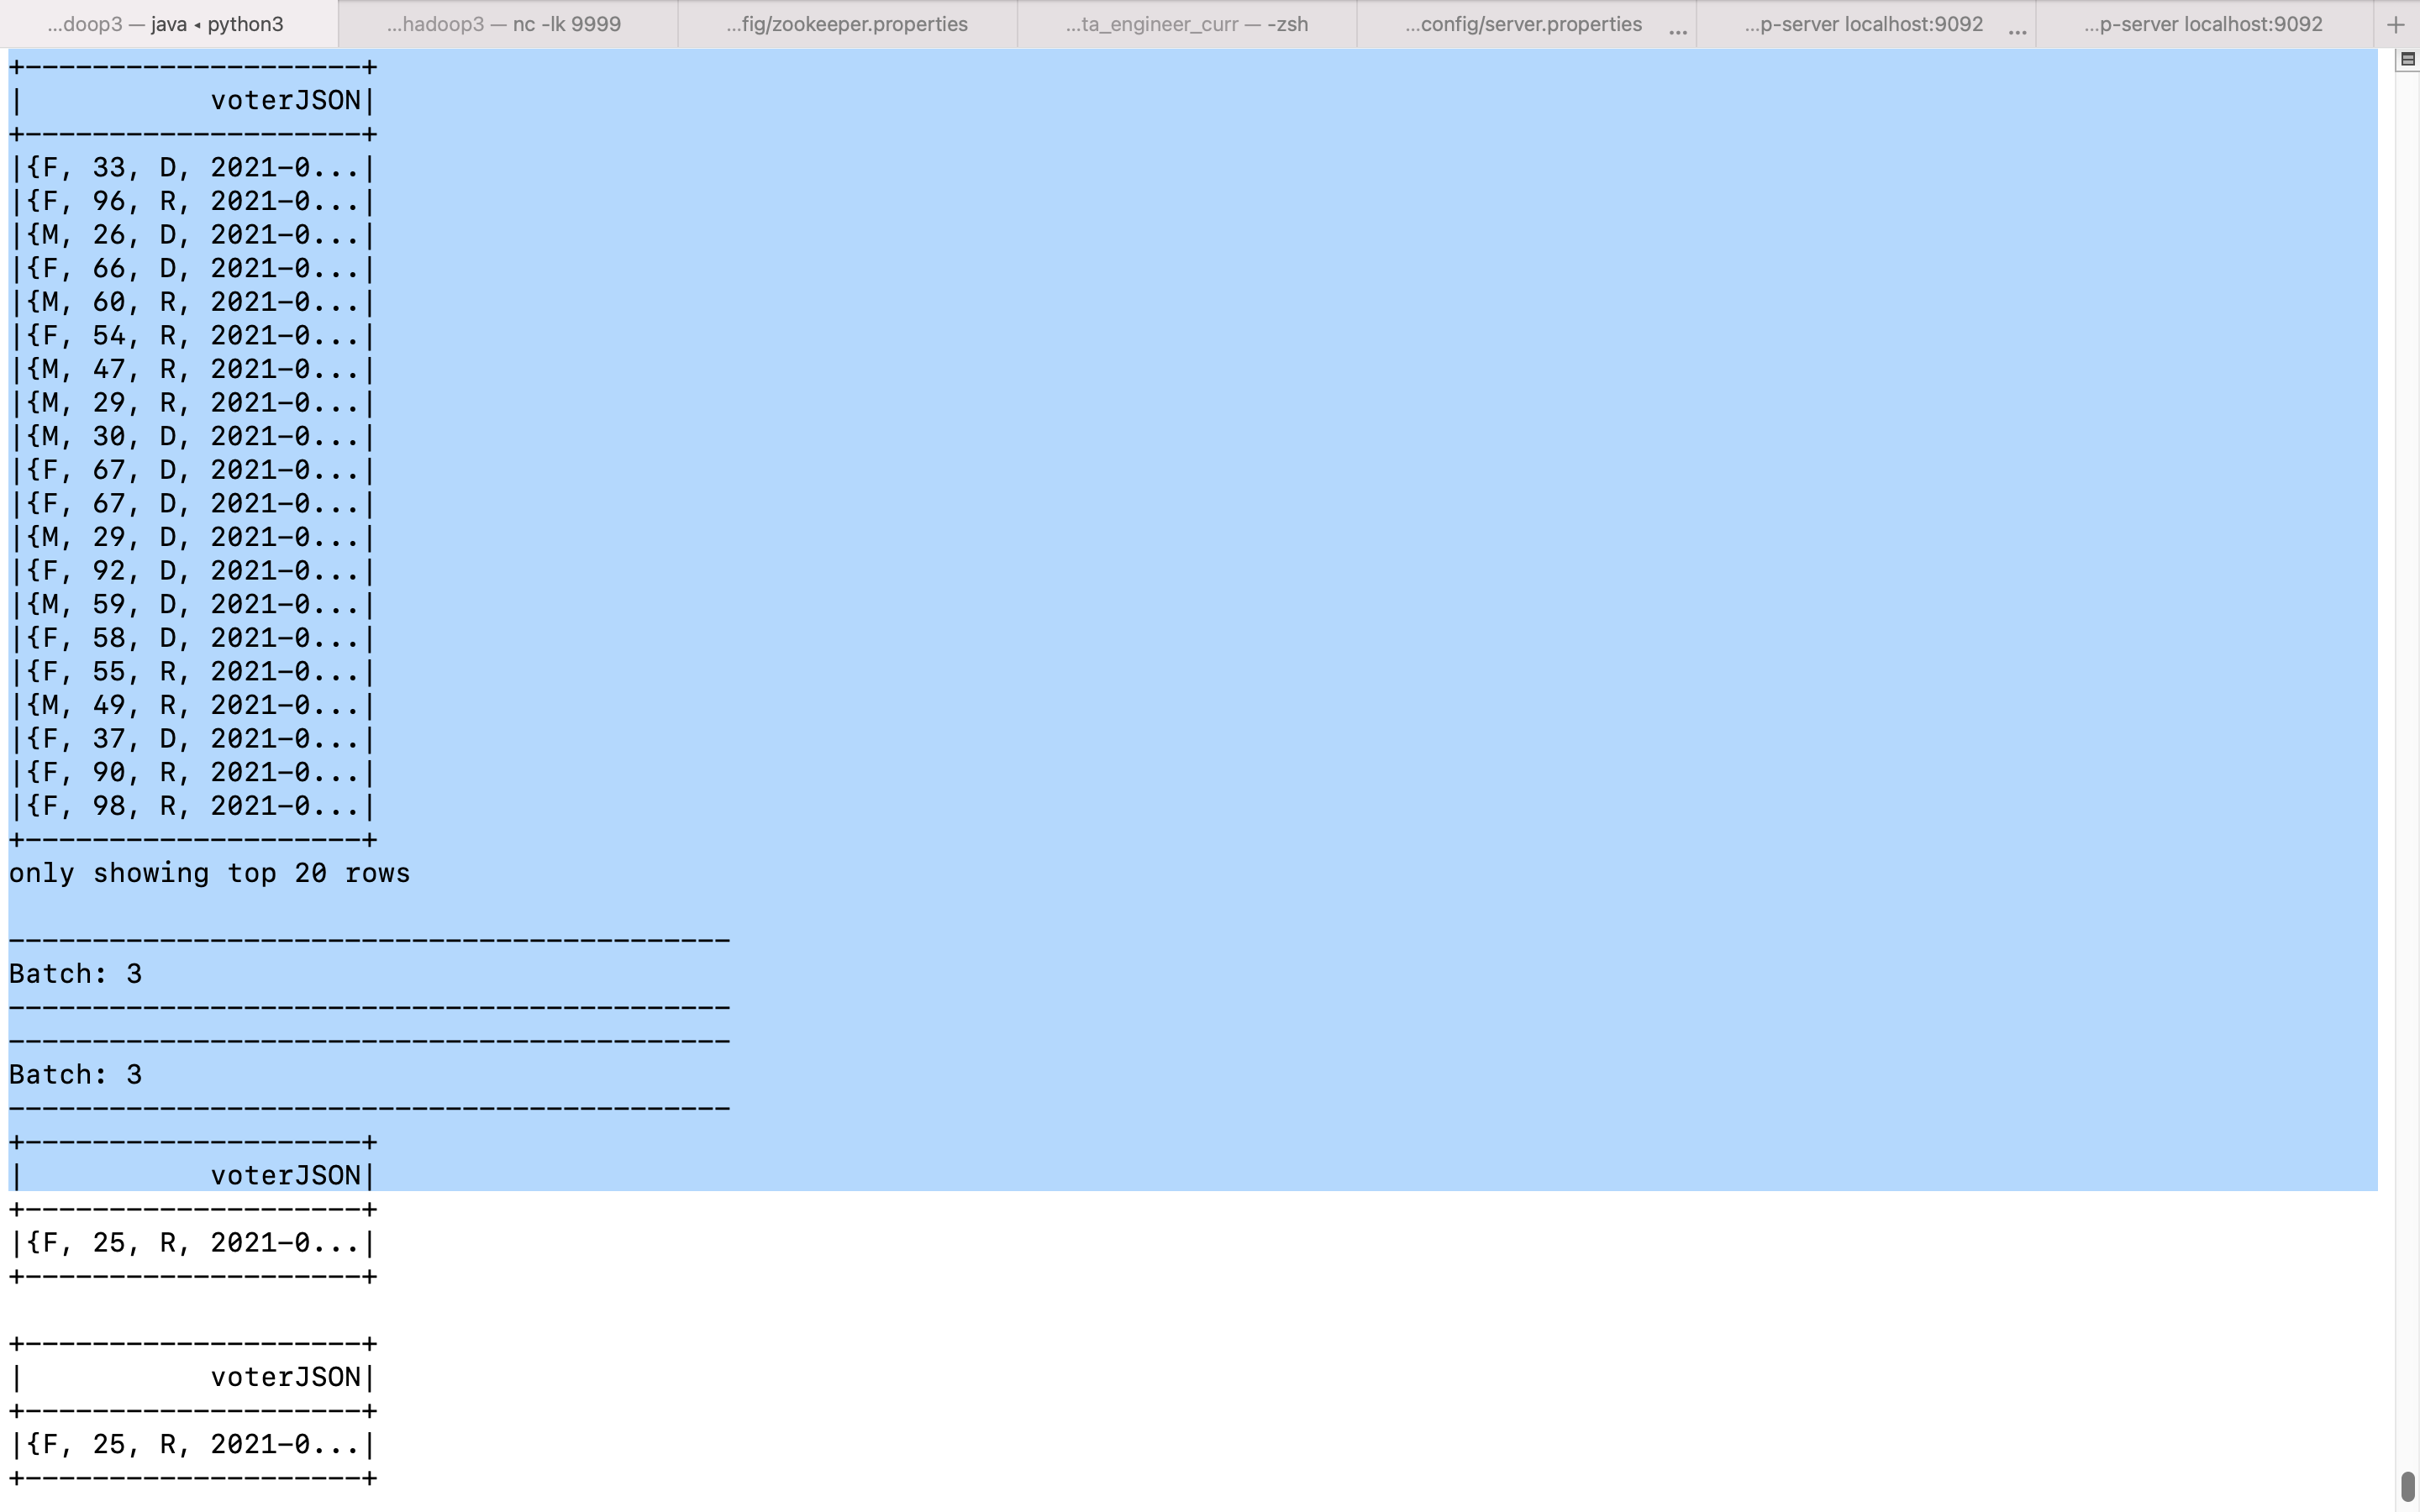

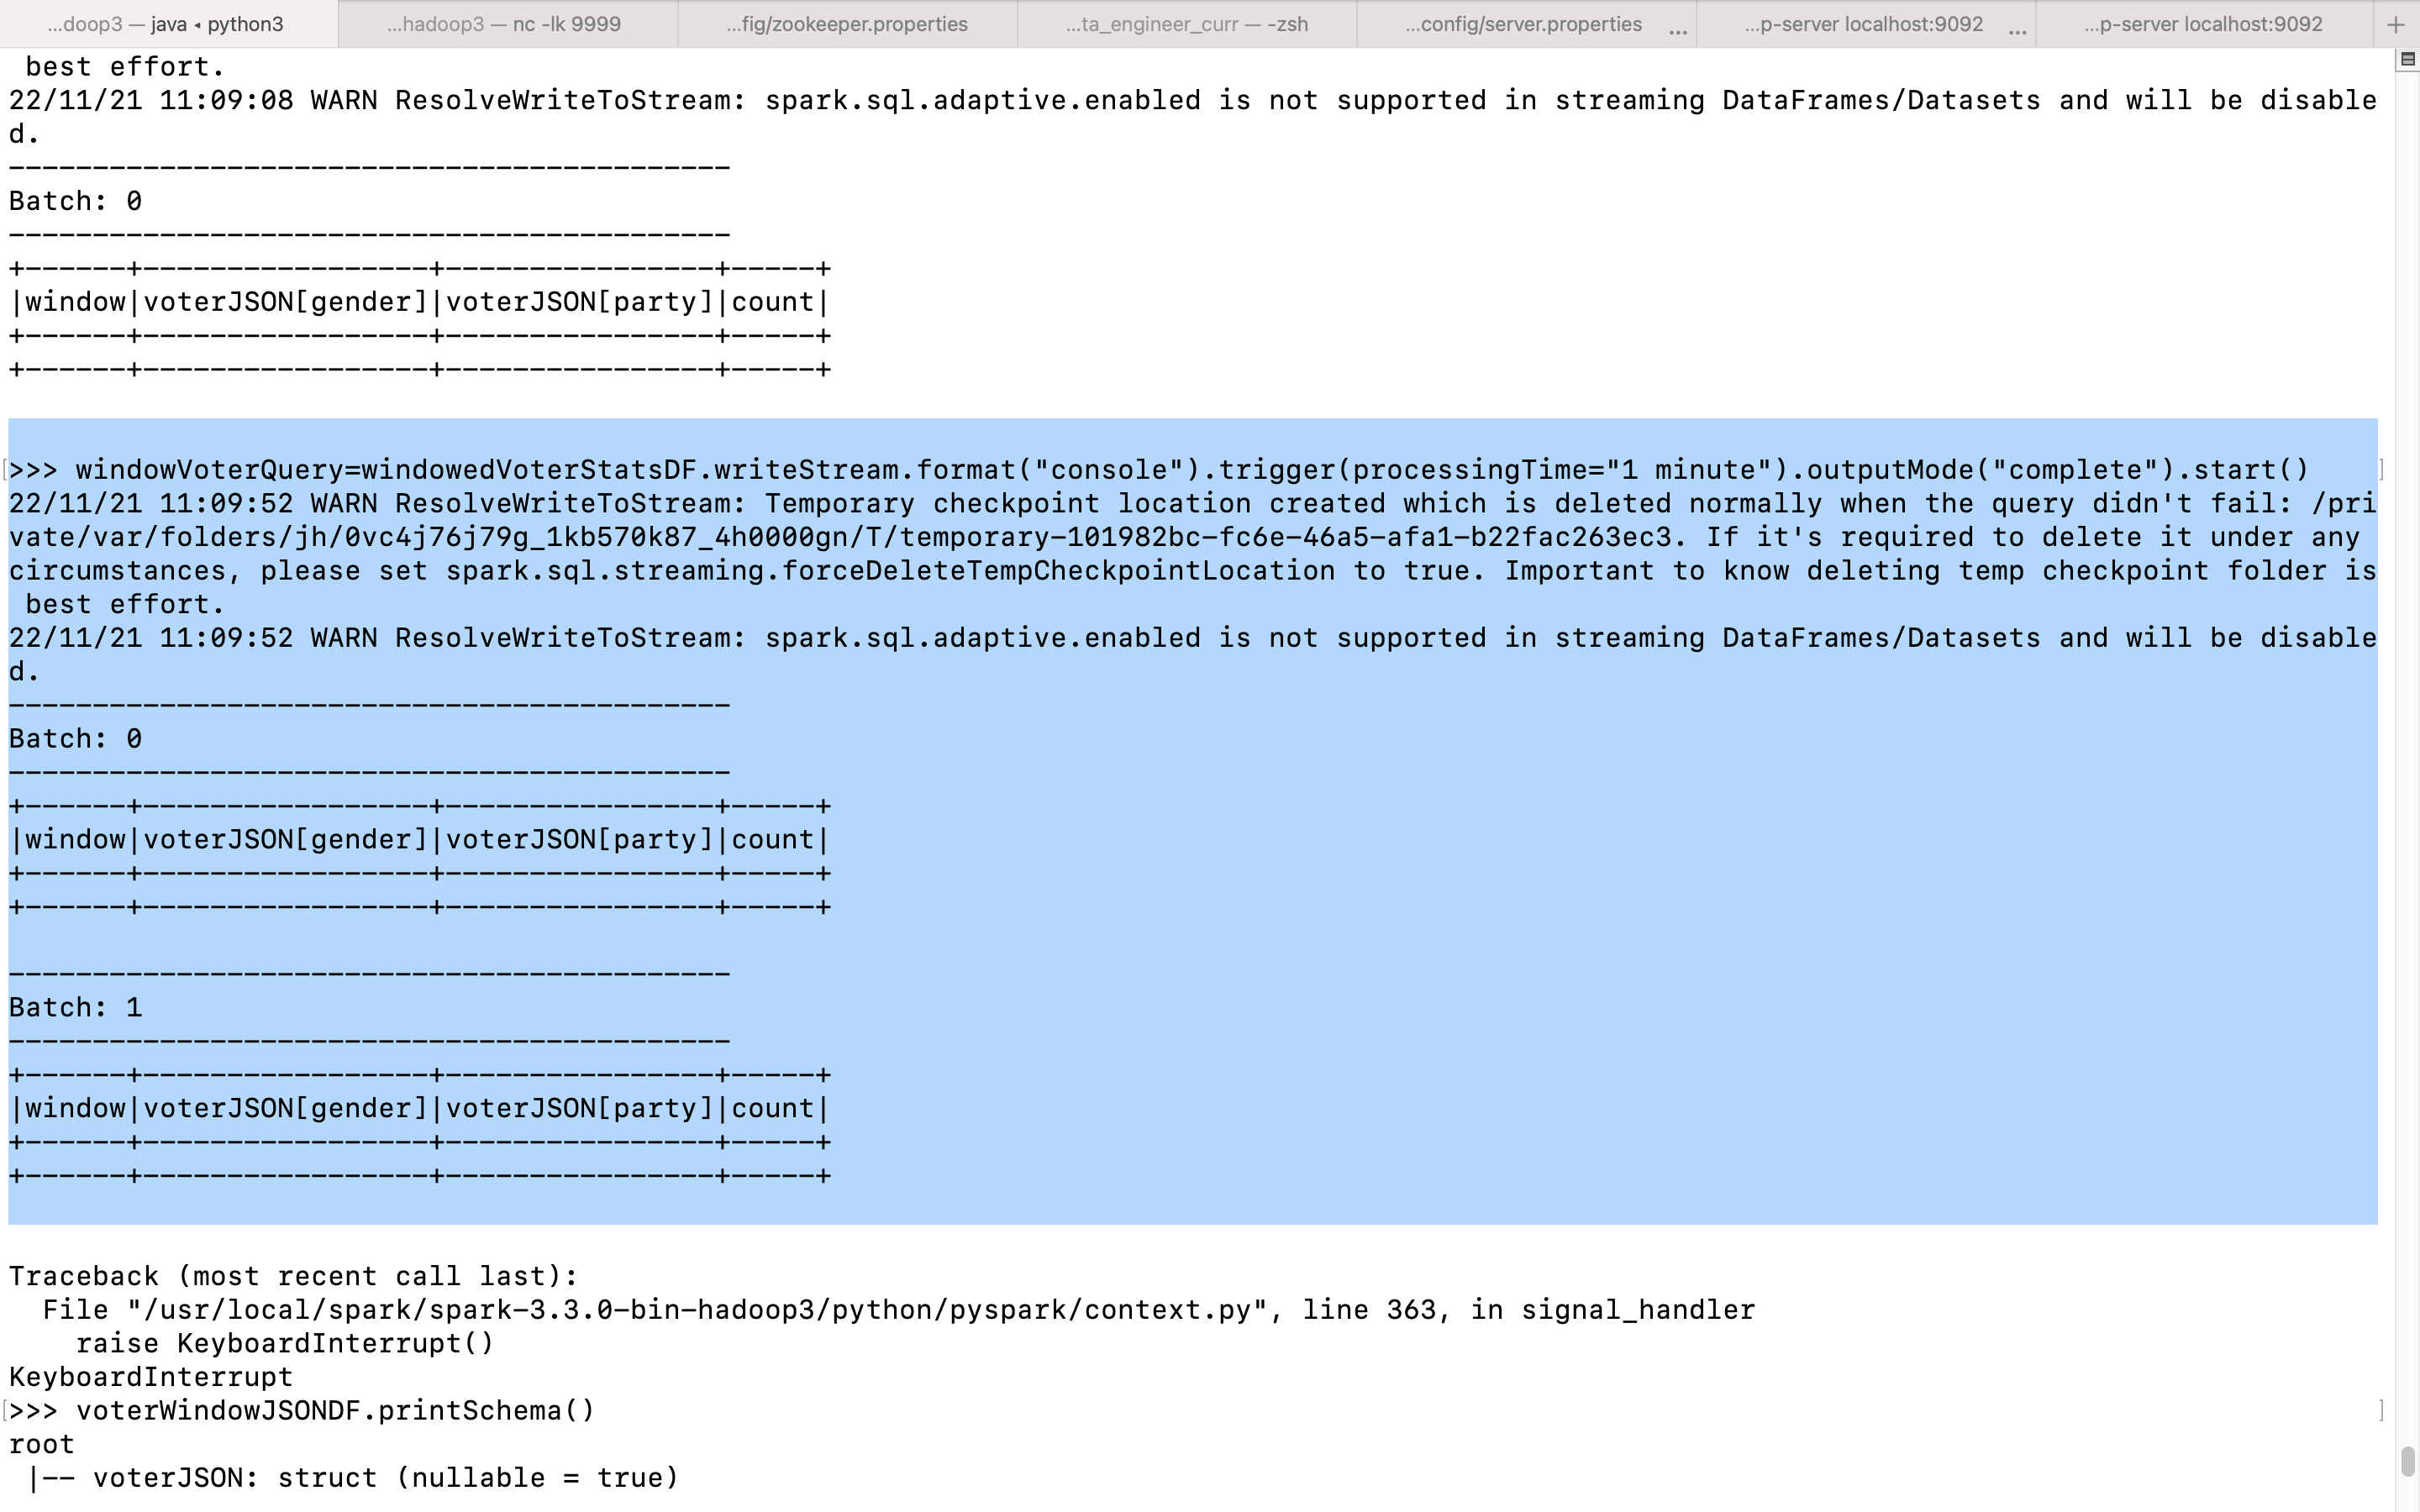

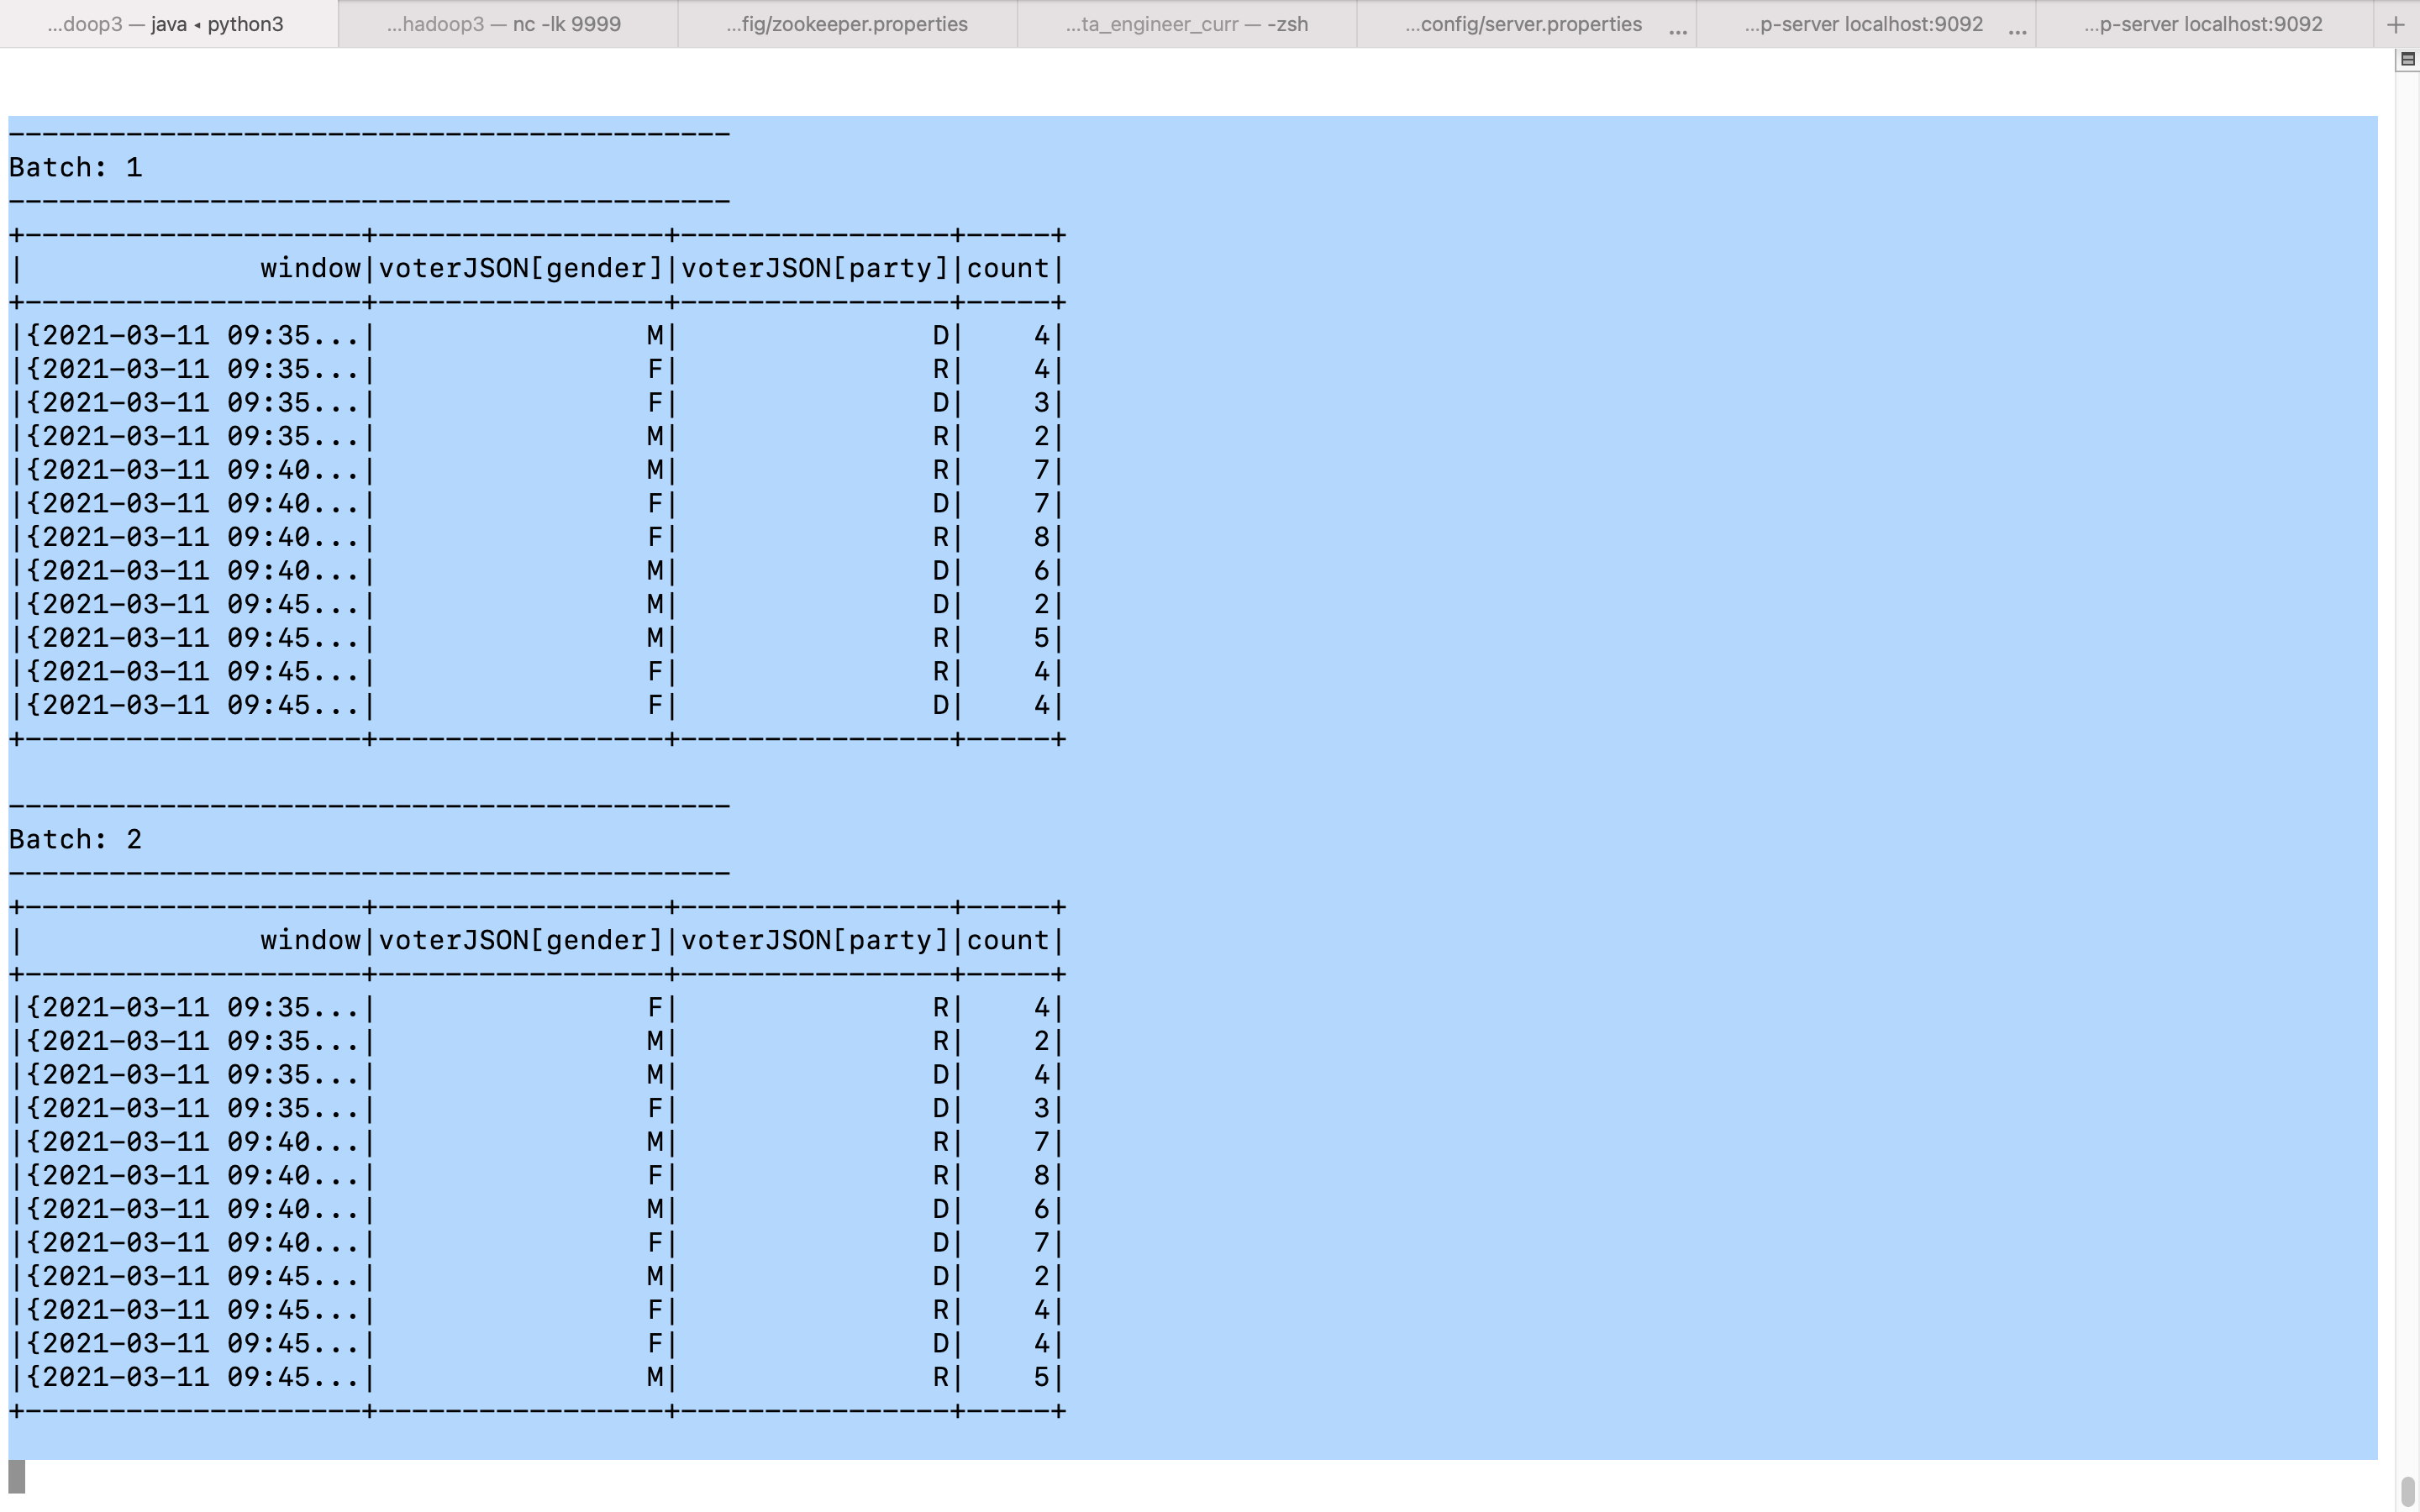

In [ ]:
from pyspark.sql.functions import split, explode, col, lower, current_timestamp, window

# Create a DataStreamReader
# Read from a socket (at localhost:9999)
lines = spark.readStream.format("socket").option("host", "localhost").option("port", 9999)

# Create a DataFrame from the DataStreamReader (call load())   
linesDF = lines.load()

splitWordsDF = linesDF.select(explode (split(col("value"), "\\s+")).alias("word")  ).select(lower(col("word")).alias("word"))

# TODO: Add a timestamp column to splitWordsDF using current_timestamp()
#timeStampedWordsDF = None
timeStampedWordsDF=splitWordsDF.withColumn("current_timestamp",current_timestamp())

# TODO: Add aggregation on 30 second window (and 30 sec slide) to dataframe below.
# Just specify the 30 second window, and the slide will default to the same value.
# You should also order by the window column.
windowedWordCountsDF = timeStampedWordsDF.groupBy(timeStampedWordsDF.word).count()

windowedWriter = windowedWordCountsDF.writeStream.trigger(processingTime="5 seconds").outputMode("complete").format("console").option("truncate", "false")

windowedQuery = windowedWriter.start()

# After you're done using it, stop it before going on.




# ************* Optional - Aggregate on 30 sec window/15 sec. slide

# TODO - OPTIONAL: Add aggregation on 30 second window and 15 sec slide to dataframe below.
# This time, you'll need to specify the window and the slide values.
slidingWindowedWordCountsDF = timeStampedWordsDF.groupBy(timeStampedWordsDF.word).count()

slidingWindowedWriter = slidingWindowedWordCountsDF.writeStream.trigger(processingTime="5 seconds").outputMode("complete").format("console").option("truncate", "false")

slidingWindowedQuery = slidingWindowedWriter.start()

# After you're done using it, stop it to complete the lab.
slidingWindowedQuery.stop()
 


##### Push Data Into Kafka - View Streaming Data
- Pusing Data from any file to Kafka topic
  -  bin/kafka-console-producer.sh --topic voter  --bootstrap-server localhost:9092 < /Users/kirtikamerkar/Downloads/spark-labs-python/data/voters-5K.json 

##### References:
- https://sparkbyexamples.com/spark/spark-streaming-with-kafka/
- https://www.linkedin.com/pulse/streaming-architecture-apache-spark-kafka-abilash-thulasidharan?trk=public_profile_article_view
- https://kafka.apache.org/
- https://medium.com/geekculture/integrate-kafka-with-pyspark-f77a49491087

In [ ]:
!jupyter nbconvert --to webpdf --allow-chromium-download Spark_structured_Streaming.ipynb
